In [3]:
%matplotlib inline
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as snb

import os
import sys
sys.path.append(os.path.abspath('..'))

from scipy.optimize import minimize
from jax import value_and_grad
from jax import hessian
from jax import random

# for plotting
from matplotlib.colors import ListedColormap

# for manipulating images
from PIL import Image

from exercise7 import PCA_dim_reduction
from exercise7 import visualize_utility
from exercise7 import add_colorbar

from jax import config
config.update("jax_enable_x64", True)

# style stuff
snb.set_theme(font_scale=1.25)
snb.set_style('darkgrid')
colors = ['r', 'g', 'b', 'y']


# 02477 Bayesian Machine Learning - Exercise 7

**Overview**

The topic of this exercise is **multi-class classification** and **decision theory**. Probability theory and Bayes' rule tell us how to summarize our knowledge about a parameter or a prediction using probability distributions.  However, often we have to reduce these distributions a single decision, e.g. does the patient have cancer or not, and decision theory tells us how to do that in a principled manner. We will see how the **posterior predictive probabilities** play a key role in making **optimal decisions** and see how the choice of **utility function** affects the resulting decisions. We will also look at how to quantify and represent the predictive uncertainty for multi-class classification and how to investigate the reliability of the posterior predictive probabilities.

Studying **Bayesian linear models** for multi-class classification problems are important for many reasons: 1) a well-designed linear model can be hard to beat if data is not abundant and 2) linear models help us understand the theory and build intuition for more complex models. Finally, 3) the last layer of most deep neural networks for classification is equivalent to a linear model with a categorical likelihood. Hence, when we learn model parameters for the last layer only in a transfer learning setting, we actually fit a linear model for classification.

- Part 1: Bayesian linear models for multi-class classification
- Part 2: Bayesian decision theory for classification
- Part 3: Image classification
- Part 4: Making decisions with a reject option
- Part 5: Model calibration


**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.


Note that the in this exercise, we will need the python packages called **PIL** (for manipulating images) and **autograd** for computing derivatives. 


## Part 1:  Bayesian linear models for multi-class classification


**From binary to multi-class classification**

In week 3, we discussed binary classification using logistic regression models. We used a *Bernoulli likelihood* with the *sigmoid inverse link function* to model the data, i.e. $y_n \sim \text{Ber}(\sigma(f(\mathbf{x}_n)))$ such that $p(y=1|\mathbf{x}, \mathbf{w}) =  \sigma(f(\mathbf{x}_n))$. Due to the binary nature of $y_n$, we used that $p(y=0|\mathbf{x}, \mathbf{w}) = 1 - p(y=1|\mathbf{x}, \mathbf{w}) = 1 - \sigma(f(\mathbf{x}_n))$, and hence, the function $f(\mathbf{x}_n)$ completely specifies the probabilities for both outcomes of $y_n$. 

This week we will work with the natural extension for multi-class classification. Consider a multi-class problem with $K$ classes and let $\mathcal{D} = \left\lbrace (\mathbf{x}_i, y_i) \right\rbrace_{i=1}^N$ denote a dataset, where $\mathbf{x}_i \in \mathbb{R}^M$ and $y_n \in \left\lbrace 1, 2, \dots, K\right\rbrace$ are the input feature and target label, respectively, for the $i$'th example. 

Since the targets are **discrete** and **unordered**, the categorical distribution with the softmax function is a standard choice:

$$\begin{align*}
y_n|\mathbf{f}_n &\sim \text{Categorical}\left[\text{softmax}(\mathbf{f}_n)\right], \tag{1} 
\end{align*}$$

where ${\mathbf{f}_n} \in \mathbb{R}^K$ is $K$-dimensional latent vector. In contrast to binary classification, $\mathbf{f}_n = f(\mathbf{x}_n) \in \mathbb{R}^K$ is now a $K$-dimensional vector. The output of the softmax-function is also a vector, where the elements are given by
$$\begin{align*}
\text{softmax}(\mathbf{f}_n)_i = \frac{\exp(\mathbf{f}_{n,i})}{\sum_{j=1}^K \exp( \mathbf{f}_{n,j})},
\end{align*}$$

where $\mathbf{f}_{n,i}$ denotes the $i$'th element of vector $\mathbf{f}_n$ and the probabilities of the categorical distribution is given by

$$\begin{align*}
\text{Categorical}(y_n = i|\mathbf{f}_n) = \text{softmax}(\mathbf{f}_n)_i.
\end{align*}$$

**Linear models for multi-class classification**

For linear models for multi-class classification, we model each entry in $\mathbf{f}_{n}$ with a separate linear model, i.e.

$$\begin{align*}
\mathbf{f}_{n, i} &= f_i(\mathbf{x}_n) = \mathbf{w}_i^T \phi(\mathbf{x}_n) \quad\text{for}\quad i = 1, \dots, K, \tag{2} 
\end{align*}$$

where $\mathbf{w}_i \in \mathbb{R}^D$ and $\phi(\cdot)$ is a feature expansion such that $\phi(\mathbf{x}_n) \in \mathbb{R}^D$. 
Instead of $\mathbf{f}_{n, i} = \mathbf{w}_i^T \mathbf{x}_n $, we could also have used Gaussian processes or neural networks if desired.

Note that the linear models in eq. (2) is equivalent to

$$\begin{align*}
\mathbf{f}_n = \mathbf{W}\phi(\mathbf{x}_n),
\end{align*}$$

where $\mathbf{W} \in \mathbb{R}^{K \times D}$ and $\mathbf{w}_i \in \mathbb{R}^D$ is the $i$'th row of $\mathbf{W}$. This set-up is equivalent to the last layer of a neural network for multi-class classification.



**The joint distribution**

To complete the Bayesian model, we impose a prior distribution for each $\mathbf{w}_i$. Specially, we impose zero-mean Gaussian prior on each $\mathbf{w}_i$ yielding the following joint distribution:

$$
\begin{align*}
p(\mathbf{y}, \mathbf{W}) = \prod_{n=1}^N p(y_n|\mathbf{W}) \prod_{i=1}^K p(\mathbf{w}_i) = \prod_{n=1}^N \text{Cat}(y_n|\text{Softmax}(\mathbf{W}\phi(\mathbf{x}_n))) \prod_{i=1}^K \mathcal{N}(\mathbf{w}_i|\mathbf{0}, \alpha^{-1}\mathbf{I}).
\end{align*}
$$



**Approximate inference using the Laplace approximation**

We will again resort to the Laplace approximation for inference because the posterior distribution is analytically intractable (why?) and use **Monte Carlo** sampling to estimate the posterior predictive probabilities $p(y^* = k|\mathbf{y}, \mathbf{x}^*)$.

Compared to the Gaussian process set-up from last week, this implementation is fairly straight forward. However, to faciliate the implementation of the Laplace approximation, we will let $\mathbf{w}_{\text{flat}} = \begin{bmatrix} \mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K \end{bmatrix} \in \mathbb{R}^{K \cdot D}$ be a *flattened* version of $\mathbf{W} \in \mathbf{R}^{K\times D}$, where $K\cdot D$ is the total number of parameters of the model. We can then define the Laplace approximation to be

$$\begin{align*}
p(\mathbf{w}_{\text{flat}}|\mathbf{y}) \approx q(\mathbf{w}_{\text{flat}}) = \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S}), 
\end{align*}$$
where $\mathbf{m} \in \mathbb{R}^{K\cdot D}$ and $\mathbf{S} \in \mathbb{R}^{K\cdot D \times K \cdot D}$. From these quantities, we can extract the marginal posterior mean and covariance for each $\mathbf{w}_i$. For exampe, the approximate marginal posterior for $\mathbf{w}_1$ is $p(\mathbf{w}_1|\mathbf{y}) \approx \mathcal{N}(\mathbf{w}_1|\mathbf{m}_1, \mathbf{S}_1)$, where the mean $\mathbf{m}_1 \in \mathbb{R}^D$ for $\mathbf{w}_1$ is given by first $D$ entries in $\mathbf{m}$ and the marginal posterior covariance $\mathbf{S}_1 \in \mathbb{R}^{D \times D}$ is the first $D \times D$-entries in $\mathbf{S}$ and so on and so forth. But note that $\mathbf{S}$ also contains information about the posterior covariance between each pair of weight vectors $\mathbf{w}_i$ and $\mathbf{w}_j$.

In this exercise, we will rely on **JaX** for computing the gradient and Hessian.



**Making predictions**

To make predictions, we approximate the *posterior predictive distribution* using *Monte Carlo estimation*. 

$$\begin{align*}
p(y^* = k|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^* =k| \mathbf{W}) q(\mathbf{W})\text{d}\mathbf{W} \approx \frac{1}{S} \sum_{j=1}^S p(y^* =k| \mathbf{W}^{(j)}) \quad\text{for}\quad \mathbf{W}^{(j)} \sim q(\mathbf{W})
\end{align*}$$

 for $j = 1, \dots, S$. To implement this, we simply draw the samples from $\mathbf{w}_{\text{flat}}^{(j)} \sim \mathcal{N}(\mathbf{w}_{\text{flat}}|\mathbf{m}, \mathbf{S})$ and then reshape each sample into $\mathbf{W}^{(j)} \in \mathbb{R}^{K\times D}$. Note that there also exists an extension of the probit approximation for multi-class classification.


**Note:** In the code we will represent the class labels as integers from $0, 1, \dots, K-1$ rather than from $1, \dots, K$ because Python counts from 0.

We will start with a small toy example with $K = 4$ classes.

(200, 1)


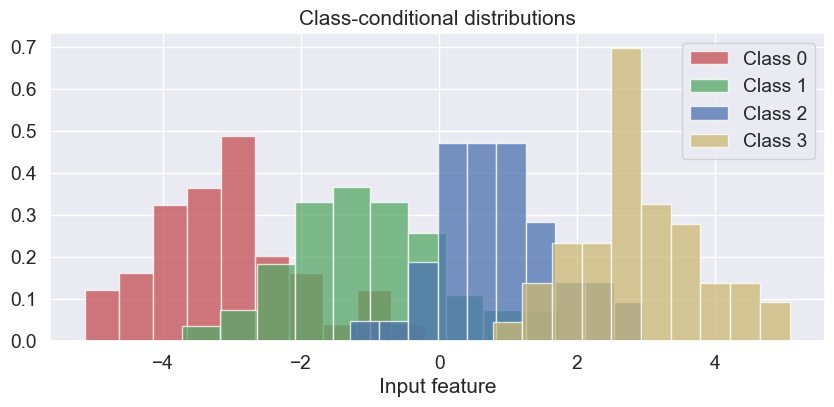

In [4]:
# seed
key = random.PRNGKey(123)
keys = random.split(key, 4)  # Split the key into 4 separate keys for generating data for each class

# number of data points per class
M = 50

# generate simple synthetic toy dataset with 4 classes
# Each class follows a normal distribution with different means
xi = [-3 + random.normal(keys[0], shape=(M, 1)),  # Class 0 centered at -3
    -1 + random.normal(keys[1], shape=(M, 1)),  # Class 1 centered at -1
     1 + random.normal(keys[2], shape=(M, 1)),  # Class 2 centered at 1
     3 + random.normal(keys[3], shape=(M, 1))]  # Class 3 centered at 3

# Combine all data points into a single array
x = jnp.concatenate(xi)

# Create labels array - 50 points for each class (0, 1, 2, 3)
y = jnp.hstack((jnp.zeros(M), jnp.ones(M), 2*jnp.ones(M), 3*jnp.ones(M)))
num_classes = 4

# Create a grid of points for later visualization and prediction
xstar = jnp.linspace(-6, 6, 300)

# Visualize the class distributions
fig, ax = plt.subplots(1,1, figsize=(10, 4))
for i in range(4):
    # Plot histogram for each class with different colors
    ax.hist(xi[i], density=True, label='Class %d' % i, alpha=0.75, color=colors[i]);
ax.set(xlabel='Input feature', title='Class-conditional distributions')
ax.legend();


print(x.shape)


**Implementation**

**Task 1.1**: Complete the implementation of the `log_prior` and `log_likelihood` functions below.

*Hints:**
- *All the parameters of the model are i.i.d. as $\mathcal{N}(0, \alpha^{-1})$ under the prior distribution.*
- *The class variable `y_onehot` contains a onehot-representations of $\mathbf{y}$. Since we rely on JaX and autograd to compute the gradients and Hessian, you can only use `jax.numpy` functions in your implementation.* 

**Task 1.2**: Complete the implementation of `predict_y` below

*Hints:*
-  *Generate the desired number of samples from $\mathbf{w}^{(j)}_{\text{flat}} \sim \mathcal{N}(\mathbf{m}, \mathbf{S})$ and then reshape each sample to $K \times D$ weight matrix, e.g. $\mathbf{W}^{(j)} \in \mathbb{R}^{K \times D}$, and then perform the Monte Carlo estimation.*
- *If you want to check your implementation of the previous task before attempting this one, you can comment out the lines `phat = ...` and `axes[2].plot(xstar, phat...`. If you do so, you should see a plot of the posterior mean of the $K$ linear models.*

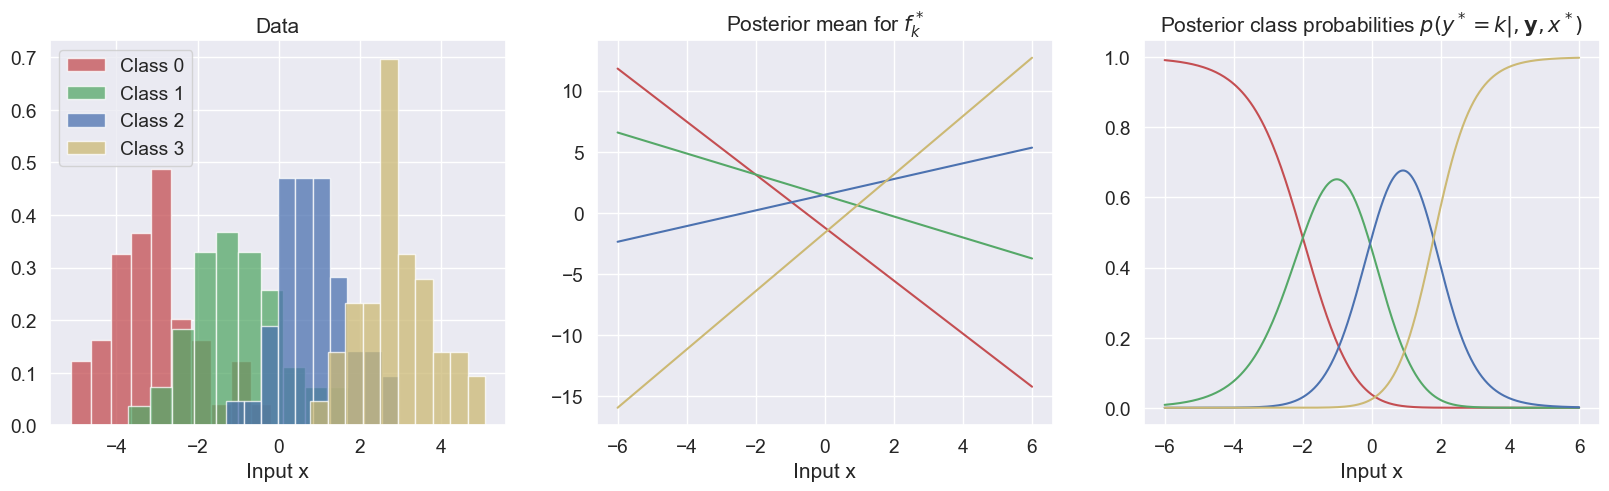

In [6]:
def log_npdf(x, m, v):
    # Log of normal probability density function
    # log p(x | m, v) = -0.5*(x-m)²/v - 0.5*log(2πv)
    return -0.5*(x-m)**2/v - 0.5*jnp.log(2*jnp.pi*v)

# convert from class label to one-hot encoding
def to_onehot(y, num_classes):
    return jnp.column_stack([1.0*(y==value) for value in jnp.arange(num_classes)])


# softmax transformation
def softmax(a):
    # Softmax function: p_i = exp(a_i) / Σ_j exp(a_j)
    exp_a = jnp.exp(a)
    b = exp_a/jnp.sum(exp_a, 1)[:, None]
    return exp_a/jnp.sum(exp_a, 1)[:, None]



class BayesianLinearSoftmax(object):
    """ Bayesian linear softmax classifier with i.i.d. Gaussian priors """
    
    def __init__(self, X, y, alpha=1):
        
        # data and prior
        self.X, self.y  = X, y
        self.N, self.D = self.X.shape
        self.alpha = alpha
        
        # num classes, parameters and one-hot encoding
        self.num_classes = len(jnp.unique(y))
        self.num_params = self.num_classes * self.D
        self.y_onehot = to_onehot(self.y, self.num_classes)
        
        # fit
        self.compute_laplace_approximation()


    def log_prior(self, w_flat):
        """ Evaluates the log prior, i.e. log p(W). 
            The function accepts the argument w_flat, which is a flattened version of W, such that the shape of w_flat is (T,), where T = num_classes x D is the total number of parameters.
            The return value of the function must be a scalar.
        """
        # Prior distribution: p(W) = Π_ij N(w_ij | 0, 1/α)
        # log p(W) = Σ_ij log N(w_ij | 0, 1/α)
        log_prior_val = jnp.sum(log_npdf(w_flat, 0, 1./self.alpha))  

        # check dimensions and return
        assert log_prior_val.shape == ()
        return log_prior_val
    
    
        
    def log_likelihood(self, w_flat):
        """ Evaluates the log likelihood for dataset (self.X, self.y) using a Categorical distribution with softmax inverse link function
            The function accepts the argument w_flat, which is a flattened version of W, such that the shape of w_flat is (T,), where T = num_classes x D is the total number of parameters.
            The return value of the function must be a scalar.
        """
        
        # reshape from flat vector to matrix of size num_classes by D
        W = w_flat.reshape((self.num_classes, self.D))

        ##############################################
        # Your solution goes here
        ##############################################
        
        # compute values for each latent function
        # f_k(x_n) = w_k^T x_n for class k and data point n
        y_all = self.X@W.T

        # normalize using softmax
        # p(y_n = k | x_n, W) = exp(f_k(x_n)) / Σ_j exp(f_j(x_n))
        p_all = softmax(y_all)
        
        # evaluate 
        # Log likelihood: log p(y | X, W) = Σ_n Σ_k y_nk log p(y_n = k | x_n, W)
        # where y_nk is the k-th element of the one-hot encoding of y_n
        loglik_val =  jnp.sum(self.y_onehot*jnp.log(p_all))
        
        ##############################################
        # End of solution
        ##############################################

        # check dimensions and return
        assert loglik_val.shape == ()
        return loglik_val
        
    def log_joint(self, w_flat):
        # Log posterior (up to normalizing constant): log p(W | y, X) ∝ log p(y | X, W) + log p(W)
        return self.log_prior(w_flat) + self.log_likelihood(w_flat)
    
    def compute_laplace_approximation(self):
        """ computes Laplace approximation of model """
        # Laplace approximation: p(W | y, X) ≈ N(W | W_MAP, S)
        # where W_MAP = argmax_W log p(W | y, X)
        # and S = [∇²_W(-log p(W | y, X))]^(-1) evaluated at W_MAP

        w_init_flat = jnp.zeros(self.num_params)
        cost_fun = lambda W: -self.log_joint(W)
        result = minimize(value_and_grad(cost_fun), w_init_flat, jac=True)

        if result.success:
            w_MAP = result.x
            self.m_flat = w_MAP[:, None]    
            # A = Hessian of negative log joint
            self.A_flat = hessian(cost_fun)(w_MAP)
            # S = inverse of Hessian (posterior covariance)
            self.S_flat = jnp.linalg.inv(self.A_flat)
            return self.m_flat, self.S_flat
        else:
            print('Warning optimization failed')
            return None, None
    
    def predict_f(self, X_star):
        """ computes the posterior distribution of f_i(x, w) = w_i^T phi(x) for all classes """
        
        # get relevant part for each of the K functions
        m = self.m_flat.reshape((self.num_classes, self.D))
        Si = [self.S_flat[i*self.D:(i+1)*self.D, i*self.D:(i+1)*self.D] for i in range(self.num_classes)]
    
        # compute mean and variance for each function
        # For each class k: f_k(x*) ~ N(m_k^T x*, x*^T S_k x*)
        # where m_k is the MAP estimate for class k weights
        # and S_k is the corresponding block of the posterior covariance
        mu_f_all_classes = X_star@m.T
        var_f_all_classes = jnp.squeeze(jnp.stack([jnp.diag(X_star@Si[i]@X_star.T) for i in range(self.num_classes)], axis=1))

        return mu_f_all_classes, var_f_all_classes
        
    
    def predict_y(self, X_star, num_samples=500, seed=123):
        """ computes and returns p(y^*=k|y, x^*) using Monte Carlo sampling
         
            Arguments:
            X_star            --         PxD prediction points
            num_samples       --         number of Monte Carlo samples to use
            seed              --         seed for random number generator

            Returns
            p_all             --         Post. pred. probabilities for each point in X_star for each class, must be PxK numpy array, where K is the number of classes
        """

        key = random.PRNGKey(seed)
        ##############################################
        # Your solution goes here
        ##############################################
        
        # generate samples (shape: num_samples x total_params)
        # W^(s) ~ N(W_MAP, S) for s = 1, ..., num_samples
        w_samples_flat = random.multivariate_normal(key, self.m_flat.ravel(), self.S_flat, shape=num_samples)

        # reshape (shape: num_classes x D x num_samples)
        W_samples = w_samples_flat.T.reshape((self.num_classes, self.D, num_samples))

        # compute samples of f_star for all classes (shape: num_classes x P x num_samples)
        # f_k^(s)(x*) = [W^(s)]_k^T x* for each sample s
        f_all_samples = X_star@W_samples

        # swap axes for convinience  (shape: num_samples x P x num_classes)
        f_all_samples = jnp.swapaxes(f_all_samples, 0, 1)
    
        # compute softmax for all individual samples (shape: P x num_classes x num_samples)
        # p(y* = k | x*, W^(s)) = softmax(f^(s)(x*))_k
        p_all_samples = softmax(f_all_samples)
        
        # compute mean over Monte Carlo samples  (shape: P x num_classes)
        # p(y* = k | y, x*) ≈ (1/S) Σ_s p(y* = k | x*, W^(s))
        p_all = p_all_samples.mean(2)
        
        ##############################################
        # End of solution
        ##############################################
        
        assert p_all.shape == (len(X_star), self.num_classes), f"The shape of p_all was expected to be ({len(X_star)}, {self.num_classes}), but the actual shape was {p_all.shape}. Please check the code"
        return p_all
    

# linear model with intercept and slope
design_matrix = lambda x: jnp.column_stack((jnp.ones(len(x)), x))

# fit model and compute predictions
model = BayesianLinearSoftmax(design_matrix(x), y)
mu_f, var_f = model.predict_f(design_matrix(xstar))
phat = model.predict_y(design_matrix(xstar))

# plot
fig, axes = plt.subplots(1,3, figsize=(20, 5))
for i in range(4):
    # plot histogram of data
    axes[0].hist(xi[i], density=True, label='Class %d' % i, alpha=0.75, color=colors[i]);
    # plot posterior mean of latent function y for each class
    axes[1].plot(xstar, mu_f[:, i], label='i = %d' % i, color=colors[i])    
    # plot posterior class probabilitites
    axes[2].plot(xstar, phat[:, i], label='i = %d' % i, color=colors[i])
    
axes[0].legend()
for i in range(3):
    axes[i].set_xlabel('Input x')
    
axes[0].set_title('Data')
axes[1].set_title('Posterior mean for $f^*_k$')
axes[2].set_title('Posterior class probabilities $p(y^*=k|, \\mathbf{y}, x^*)$');

In [5]:
print(phat.shape)
print(phat[0:5, :])

(300, 4)
[[9.91717259e-01 8.27951636e-03 3.22461465e-06 7.68318658e-11]
 [9.91349448e-01 8.64701700e-03 3.53517976e-06 8.75671182e-11]
 [9.90964704e-01 9.03141985e-03 3.87601437e-06 9.98186740e-11]
 [9.90562229e-01 9.43352044e-03 4.25010283e-06 1.13803250e-10]
 [9.90141187e-01 9.85415190e-03 4.66072688e-06 1.29768935e-10]]


**Task 1.3**: Study the plots above. Explain the role of the softmax-function in eq. (1) above and use the figures above to explain why the name "softmax" makes sense [**Discussion question**]


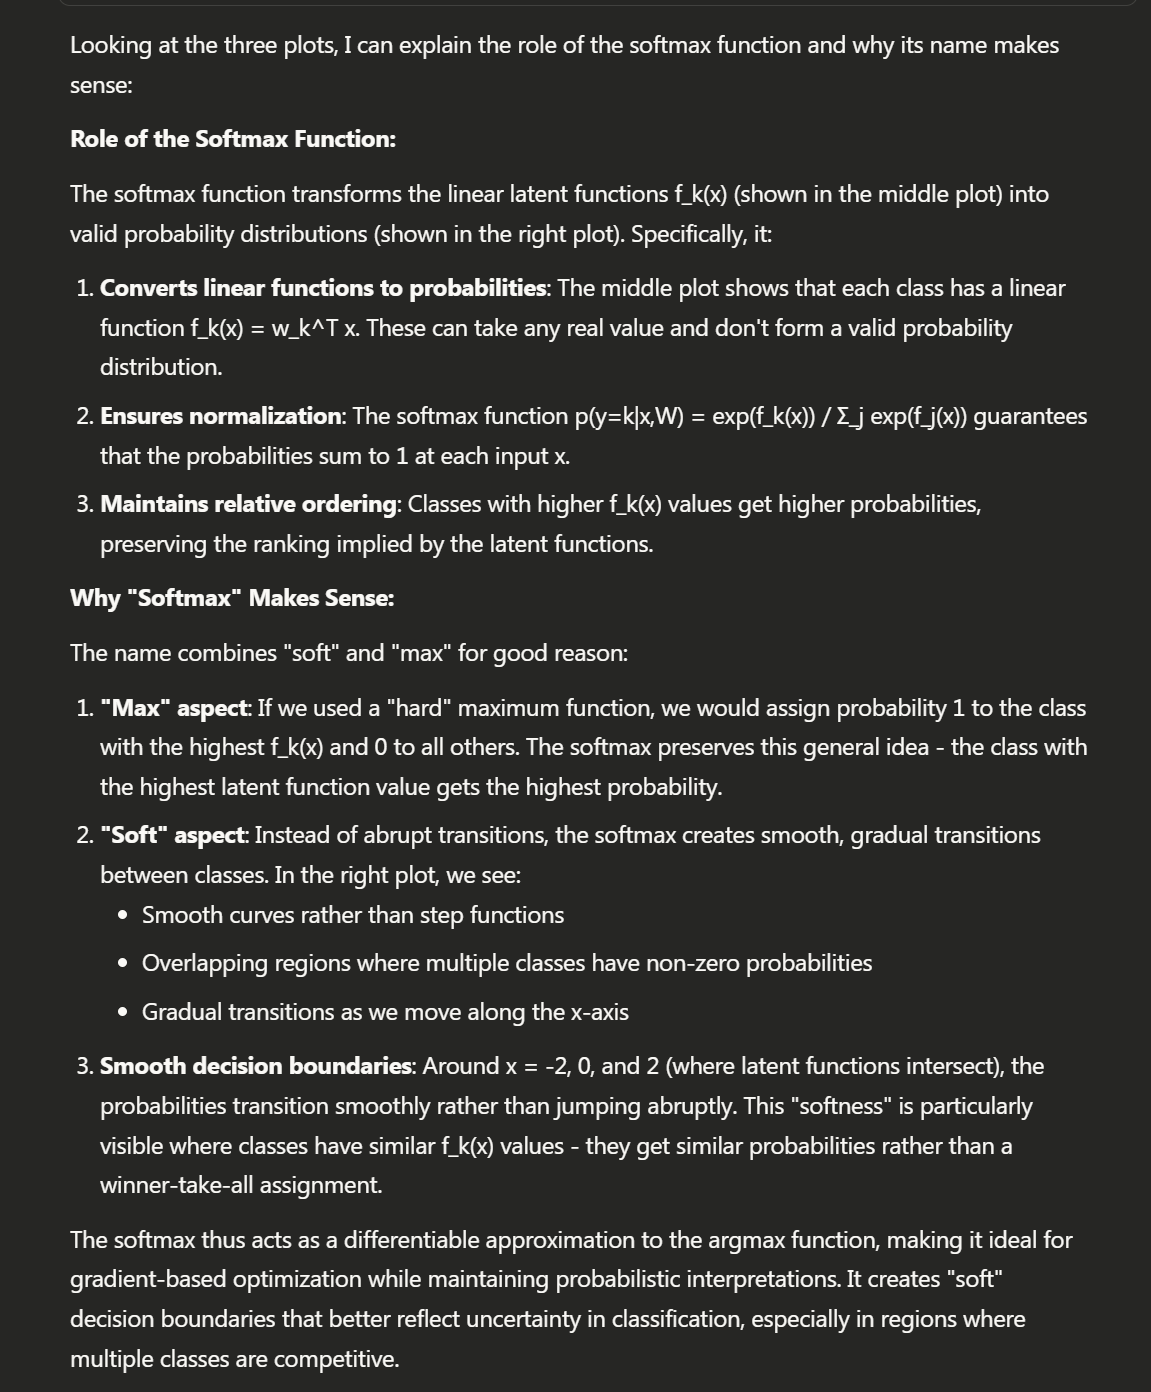

**Task 1.4**: Implement and plot the **confidence** and **entropy** for the predictive distributions above for each value of $x$ in the vector `xstar` (similar to the rightmost plot above). Comment on the relation between the confidence and entropy plots and the posterior predictive probabilities.



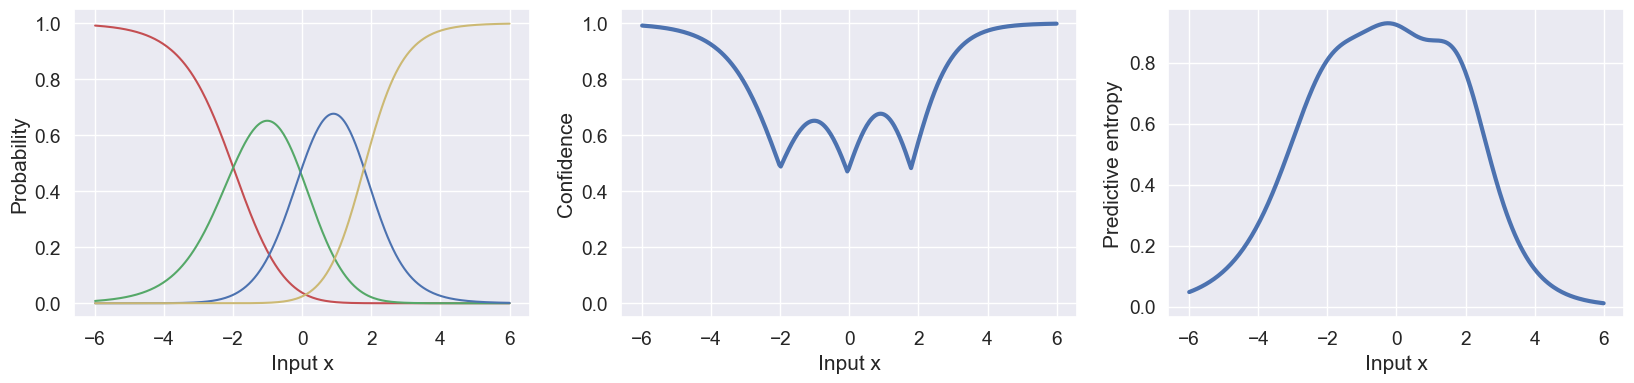

In [7]:
def confidence(p):
    """
    Computes the confidence for each predictive distribution.

    The confidence is defined as the maximum predicted probability for each sample:
        confidence(x^*) = max_k p(y^*=k | x^*, D)
    where D is the training data.

    Parameters
    ----------
    p : jax.numpy.ndarray
        Posterior predictive probabilities for each sample and class.
        Shape: (N, K), where N is the number of prediction points and K is the number of classes.

    Returns
    -------
    conf : jax.numpy.ndarray
        Confidence for each prediction point.
        Shape: (N,)

    Equation
    --------
    conf_n = max_k p_{n,k}
    """
    return jnp.max(p, axis=1)

def entropy(p):
    """
    Computes the predictive entropy for each predictive distribution.

    The entropy measures the uncertainty of the predictive distribution:
        entropy(x^*) = -sum_k p(y^*=k | x^*, D) * log(p(y^*=k | x^*, D))

    Parameters
    ----------
    p : jax.numpy.ndarray
        Posterior predictive probabilities for each sample and class.
        Shape: (N, K), where N is the number of prediction points and K is the number of classes.

    Returns
    -------
    ent : jax.numpy.ndarray
        Predictive entropy for each prediction point.
        Shape: (N,)

    Equation
    --------
    ent_n = -sum_k p_{n,k} * log(p_{n,k})
    """
    return -jnp.sum(p * jnp.log(p), axis=1)


fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i in range(4):
    ax[0].plot(xstar, phat[:, i], label='i = %d' % i, color=colors[i])
ax[0].set(xlabel='Input x', ylabel='Probability', ylim=(-0.05, 1.05))
ax[1].plot(xstar, confidence(phat), linewidth=3)
ax[1].set(xlabel='Input x', ylabel='Confidence', ylim=(-0.05, 1.05))
ax[2].plot(xstar, entropy(phat), linewidth=3)
ax[2].set(xlabel='Input x', ylabel='Predictive entropy');

## Part 2:  Bayesian decision theory for classification

Making a decision for multi-class classification entails assigning a class label $\hat{y}^* \in \left\lbrace 1, 2, \dots, K\right\rbrace$ to a new test point $\mathbf{x}^*$. In Bayesian decision theory, the utility function $\mathcal{U}(y^*, \hat{y})$ specifies the **utility** (i.e. gain) for predicting $\hat{y}^*$ when the true target is $y^*$.

In practice, we don't know the true target $y^*$, but the predictive posterior distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$ contains all the relevant knowledge about $y^*$ given our observed data $\mathbf{y}$. Therefore, we compute the **expected utility** wrt. the posterior predictive distribution for each possible value of $\hat{y}$ and then assign the class label that **maximizes the expected utility**. That is,

\begin{align*}
\hat{y}^* = \arg\max\limits_{k \in \left\lbrace 1, 2, \dots, K\right\rbrace} \mathbb{E}_{p(y^*|\mathbf{y}, \mathbf{x}^*)}\left[\mathcal{U}(y^*, \hat{y}=k)\right]
\end{align*}

Since $p(y^*|\mathbf{y}, \mathbf{x}^*)$ is a discrete probability distribution with probabilities $p(y^* = k|\mathbf{y}, \mathbf{x}^*) = \pi_k$, expectations with respect to $p(y^*|\mathbf{y}, \mathbf{x}^*)$ is simply a weighted sum.

In the videos we saw that in order to make optimal decisions under the **0/1-utility function** (remember utility is just negative loss and vice versa), we simply have to pick the class label with largest posterior probability. Let's investigate this empirically and study how the decision regions change when we change the utility-function.

**Task 2.1**: Complete the implementation of the function `compute_expected_utility`

*Hints: How do we compute expectations with respect to discrete distributions?*

(4, 4)
(300, 4)


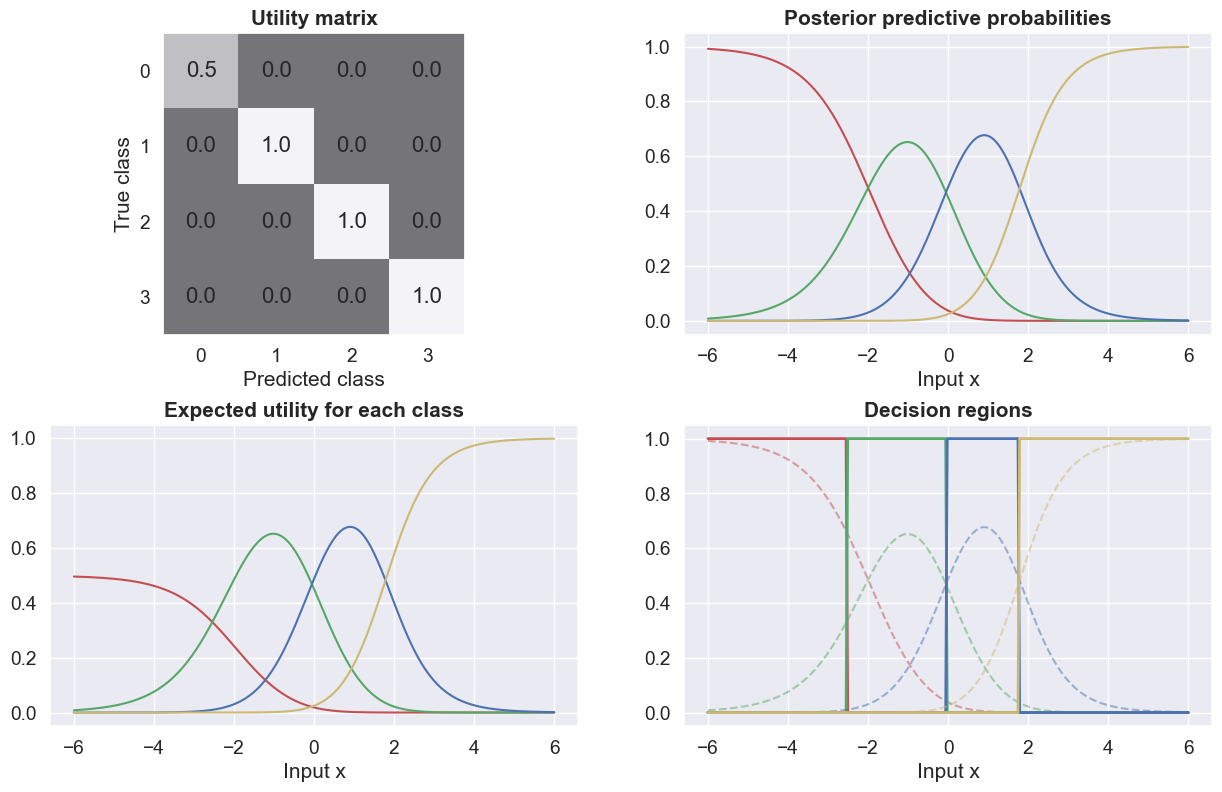

In [9]:
def compute_expected_utility(U, phat):
    """ computes the expected utility for a multi-class classification problem with K classes for utility matrix U and posterior predictive probabilities phat 
        
        Arguments
        U               --      Utility matrix (shape: [K x K])
        phat            --      Posterior predictive probabilities (shape: [P x K]), where P is the number of prediction points

        expected_util   --      Expected utility for each class for each point in phat (shape: P x K)           
           """
    

    print(U.shape)
    print(phat.shape)
    expected_util = phat @ U
    

    # check dimensions and return
    assert expected_util.shape == phat.shape, f'The variable expected_util was expected to have shape {phat.shape}, but the actual shape was {expected_util.shape}. Please check your code.'
    return expected_util

# define utility matrix
U = jnp.identity(num_classes) 


################################################################################################
## Exercise 2.4 
# Assuming U is a JAX array
#U = U.at[0, 1].set(-1)  # Note the comma between indices
#U = U.at[0, 1].set(-2)  # Note the comma between indices
#print(U)
################################################################################################

################################################################################################
# Exercise 2.5 
#U = U.at[2, 3].set(1)
#U = U.at[2, 3].set(1)
################################################################################################


################################################################################################
# exercise 2.6
U = U.at[0, 0].set(0)
U = U.at[0, 0].set(0.5)

################################################################################################
# compute the expected utility for each class
expected_utility = compute_expected_utility(U, phat) 

# make decisions
decisions = to_onehot(jnp.argmax(expected_utility, axis=1), num_classes)
    
# plot everything
fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# utility matrix
visualize_utility(axes[0,0], U)

# posterior predictive probs
for i in range(num_classes):
    axes[0,1].plot(xstar, phat[:, i], color=colors[i])
axes[0,1].set_title('Posterior predictive probabilities', fontweight='bold')
axes[0,1].set_xlabel('Input x')

# expected utility
for i in range(num_classes):
    axes[1,0].plot(xstar, expected_utility[:, i], color=colors[i]);
axes[1,0].set_title('Expected utility for each class', fontweight='bold')
axes[1, 0].set_xlabel('Input x')

# decisions
for i in range(num_classes):
    axes[1,1].plot(xstar, decisions[:, i], color=colors[i], linewidth=2);
    axes[1,1].plot(xstar, phat[:, i], color=colors[i], alpha=0.5, linestyle='--')
axes[1,1].set_title('Decision regions', fontweight='bold')
axes[1,1].set_xlabel('Input x')
fig.subplots_adjust(hspace=0.3)
    
    
colors = ['r', 'g', 'b', 'y']

**Task 2.2**: Use the figure above to explain how Bayesian decision theory works for multi-class classification. [**Discussion question**]

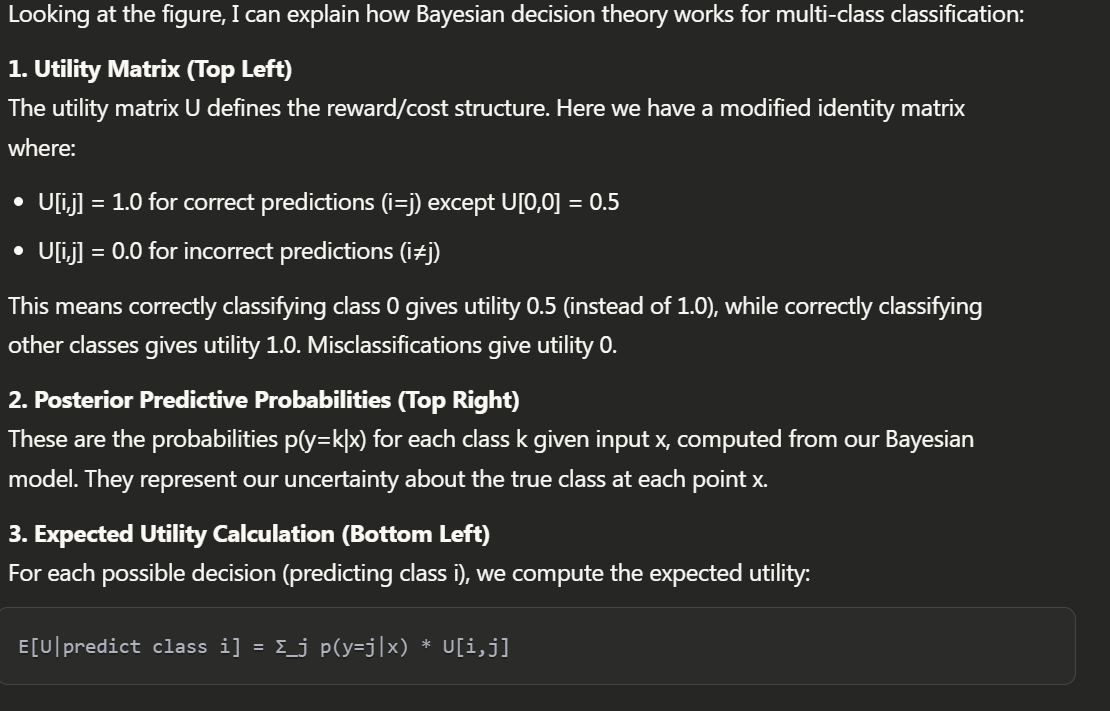

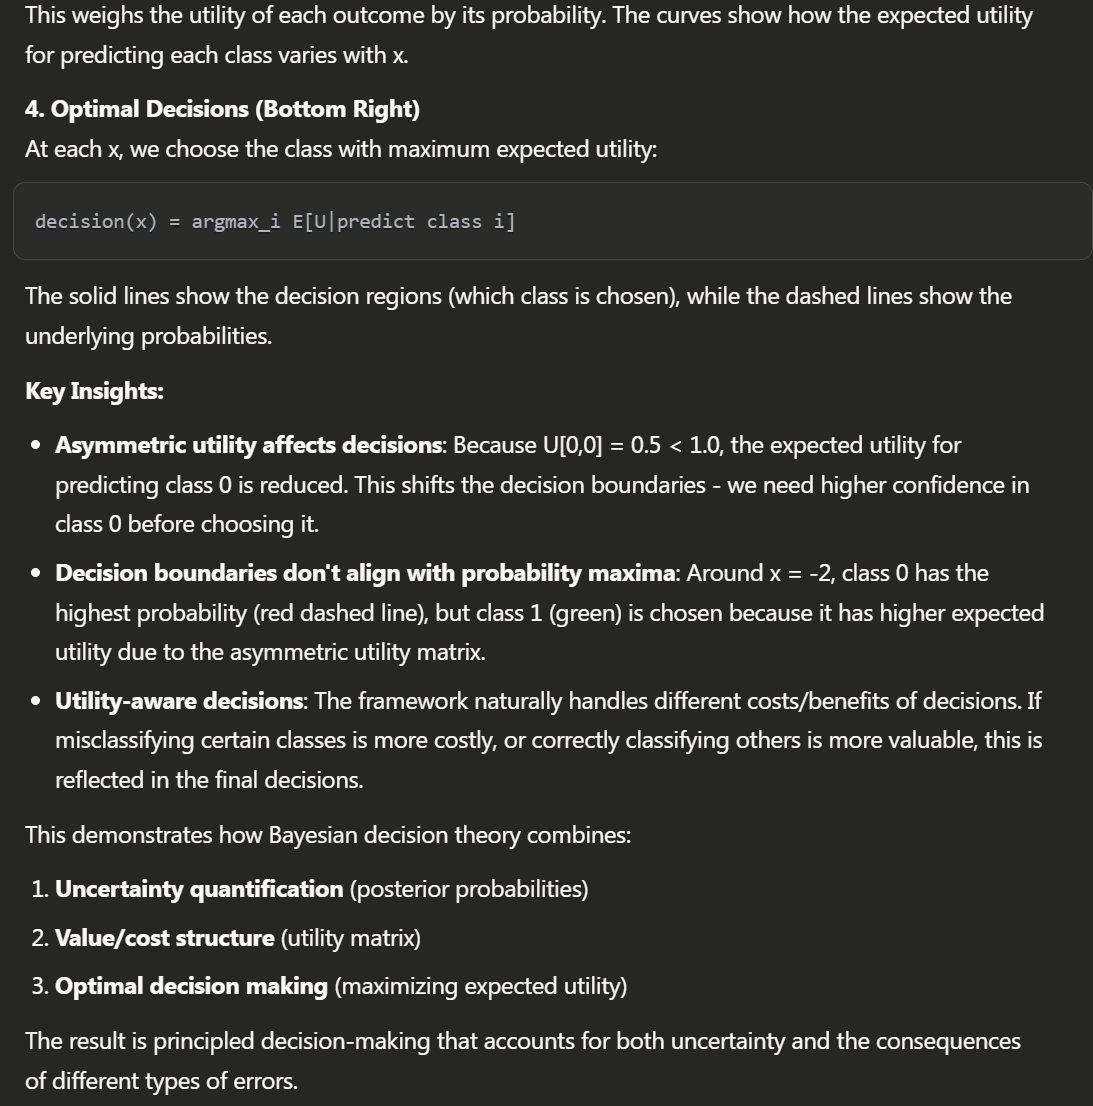

**Task 2.3**: What happens to the expected utilities and to the decisions if you scale the utility matrix by a positive constant? [**Discussion question**]

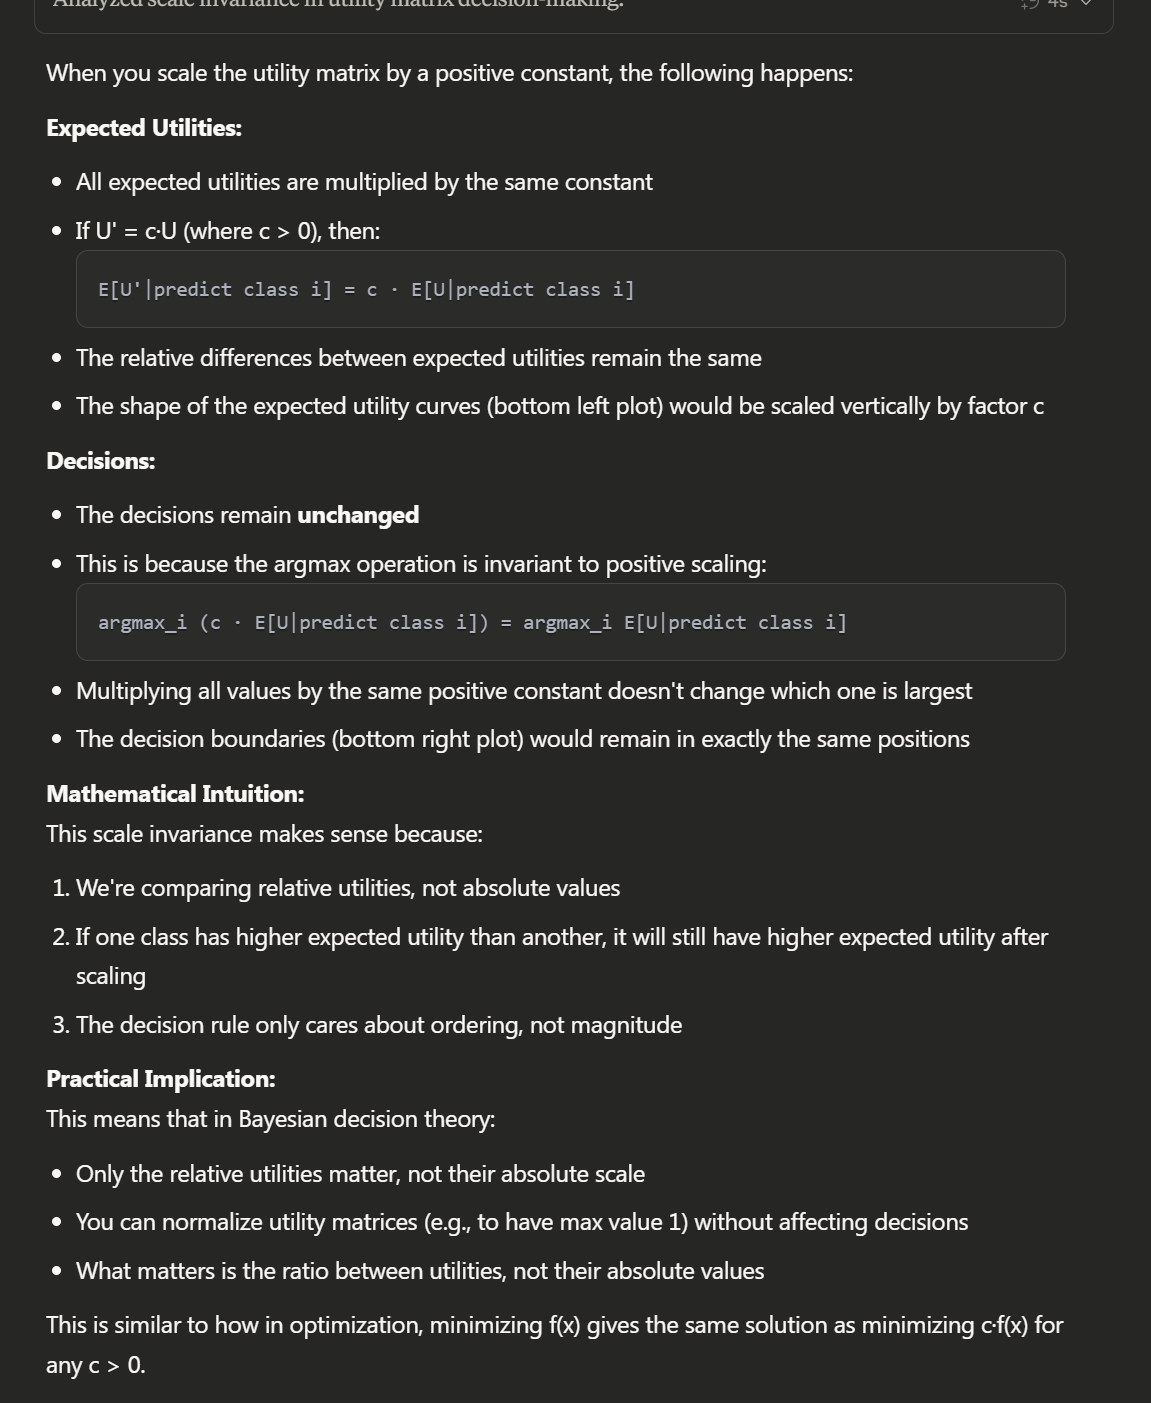

**Task 2.4**: What happens to the decision boundary if you introduce a negative utility of $-1$ for predicting 1 (green), when the true target is 0 (red)? What about $-2$? [**Discussion question**]

## The old one for comparison: 

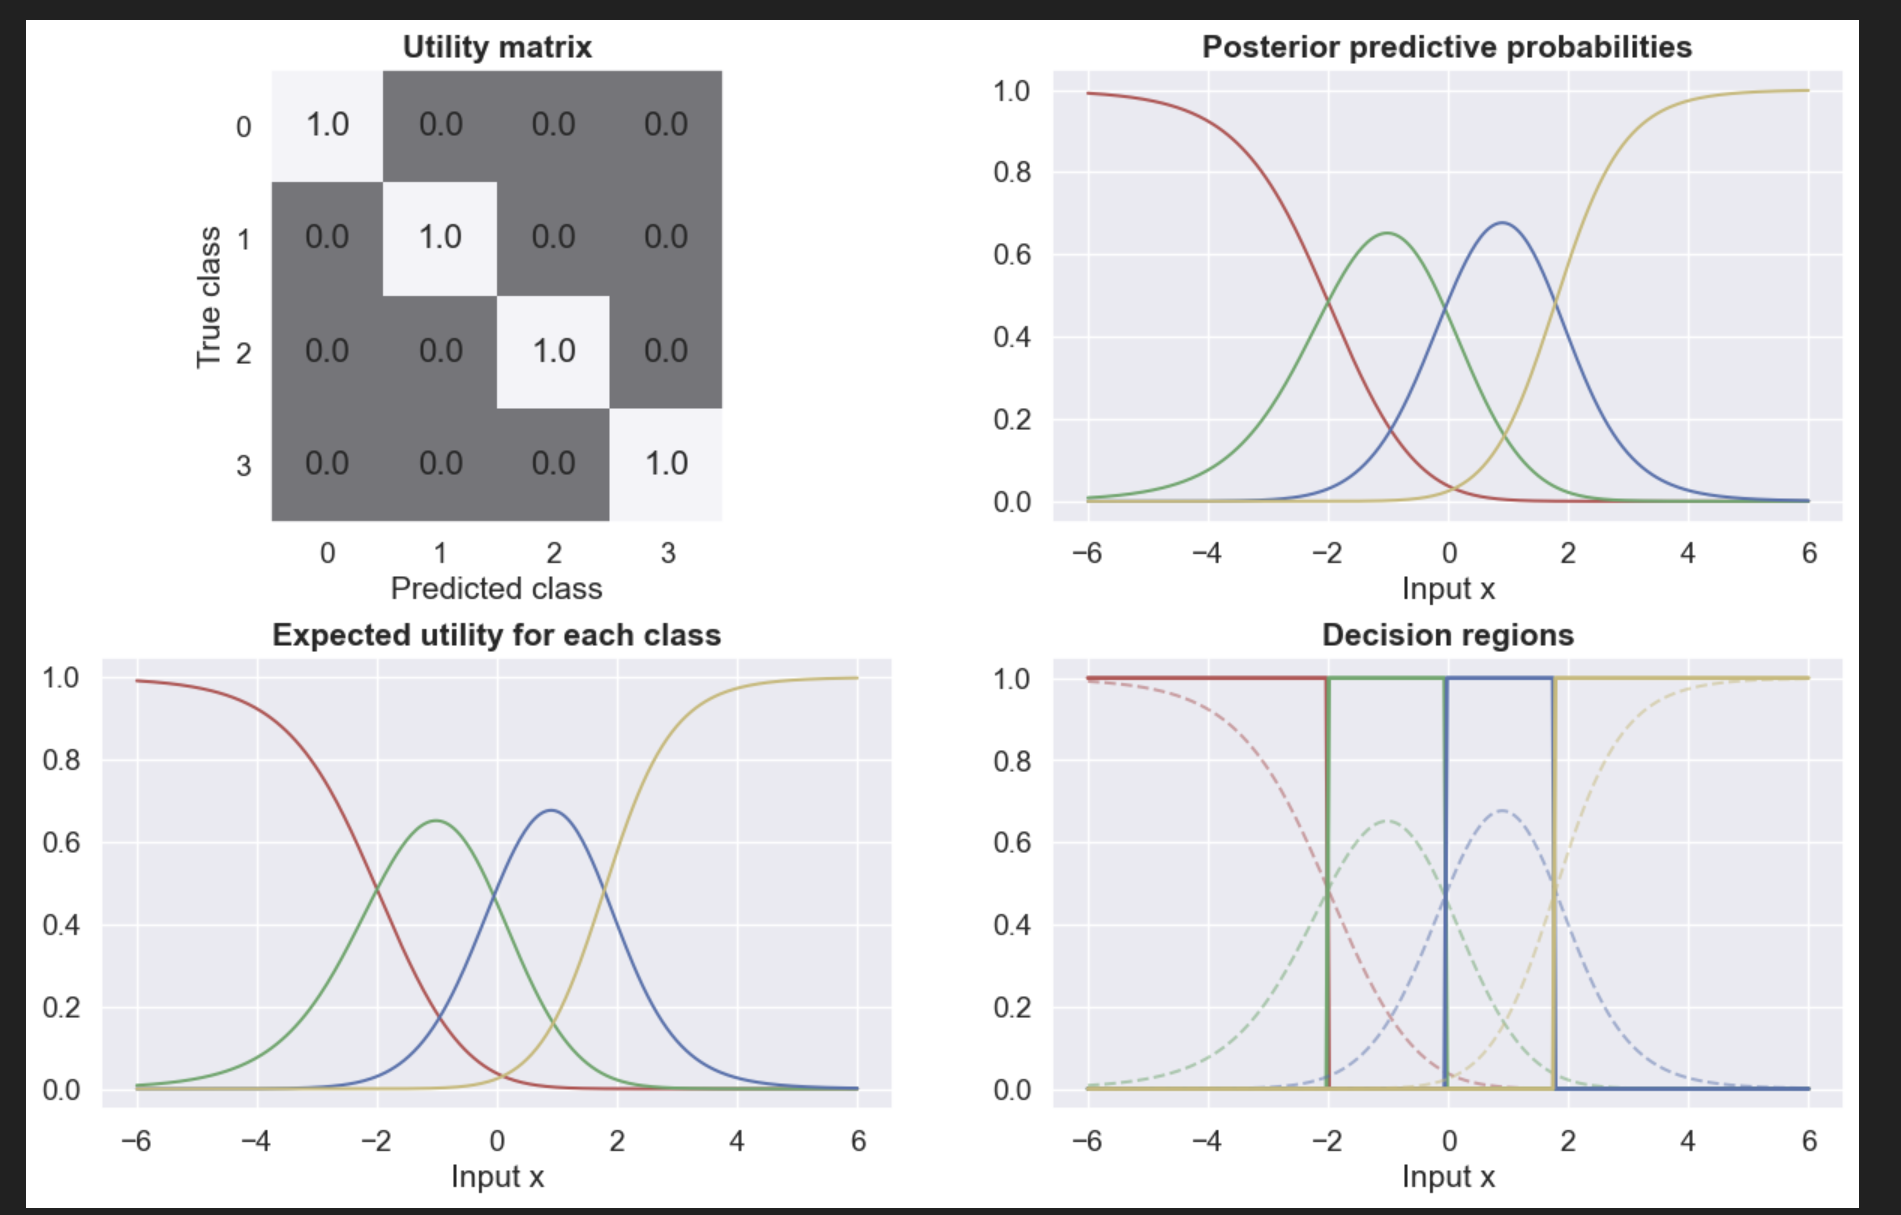

____________

### Utility of -1 

#### We do the following in code:
```python
U = U.at[0, 1].set(-1)  # Note the comma between indices
print(U)
```

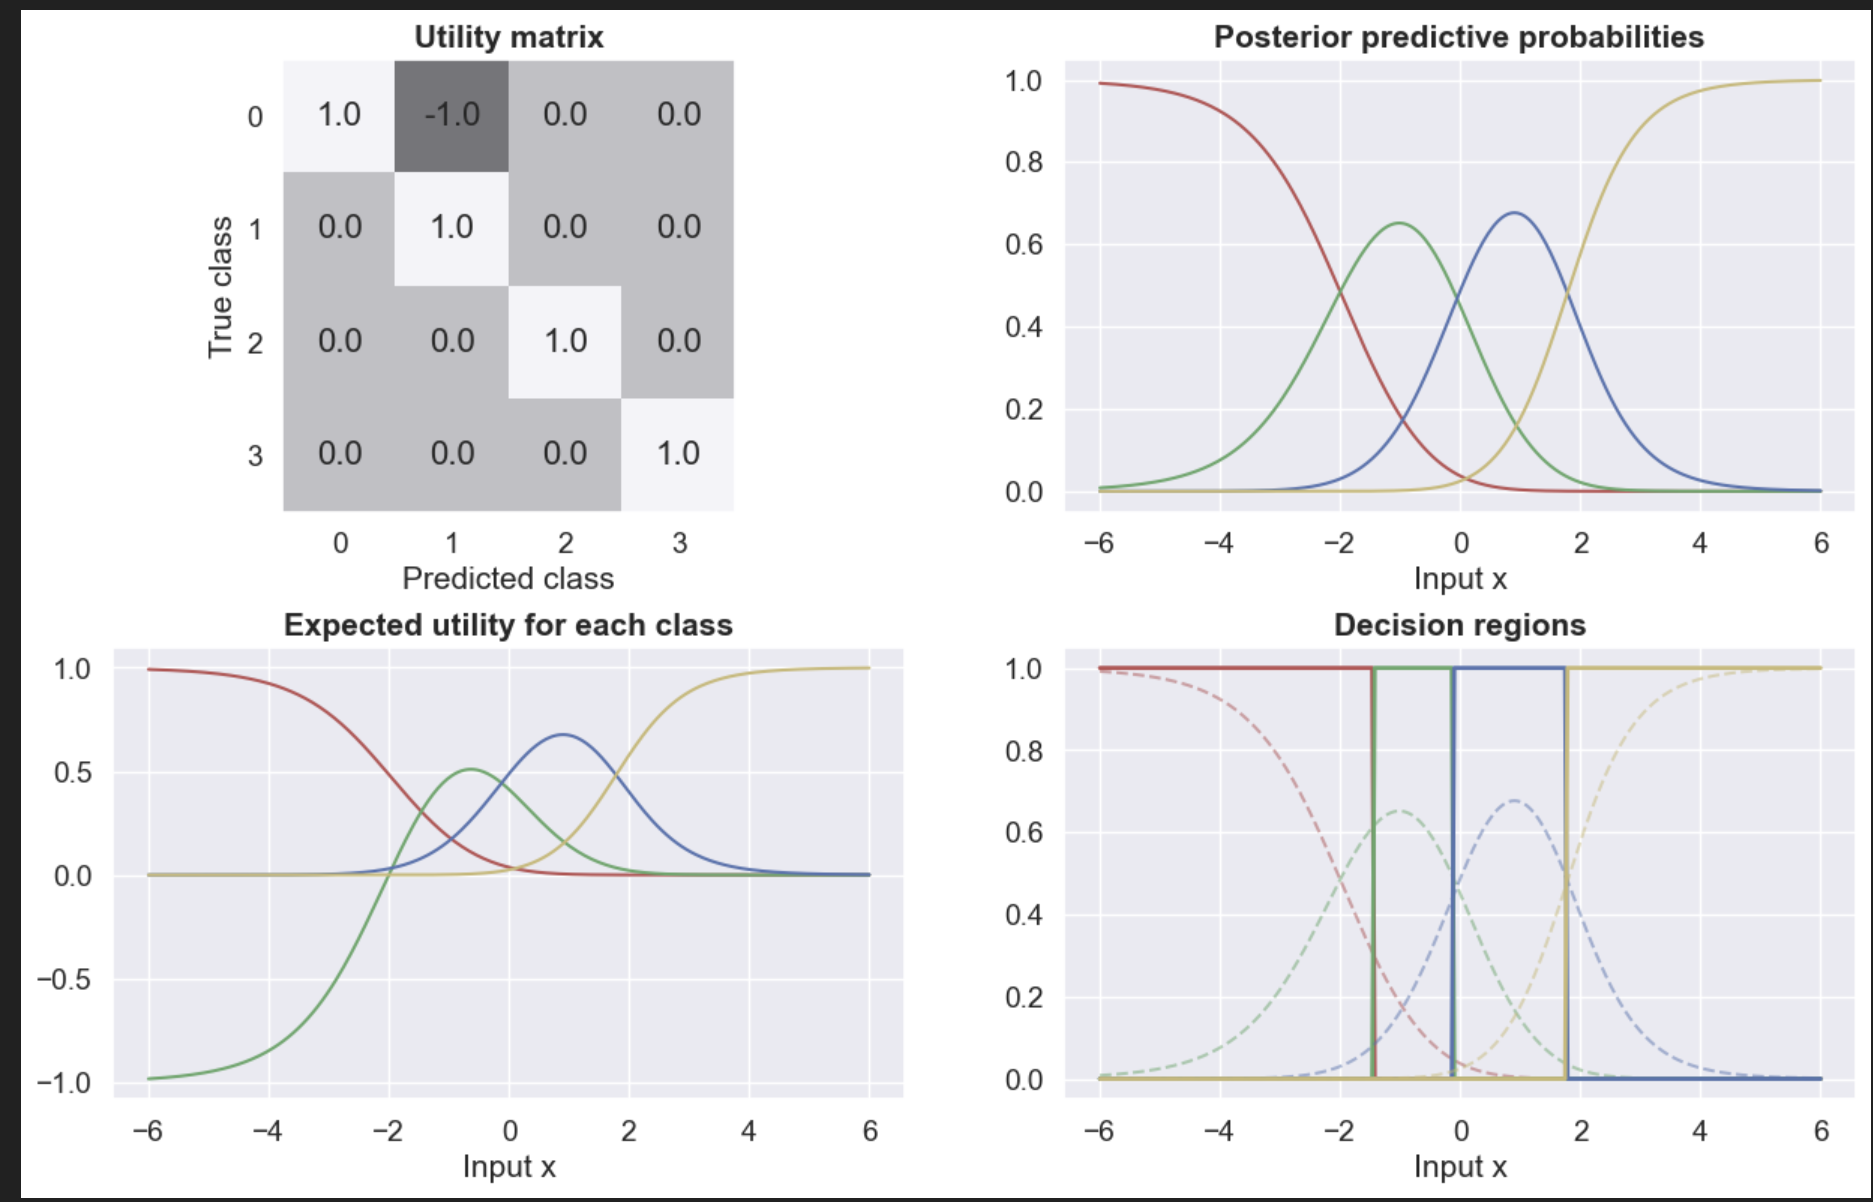


#### Utility Matrix

- The modified utility matrix shows -1.0 at position [0,1]
- This penalizes the specific error of predicting class 1 (green) when the true class is 0 (red)
- All other values remain unchanged from the identity matrix

#### Expected Utility for Each Class

- Notice how the green curve (class 1) dips below zero in regions where the red curve (class 0) has high probability
- This is because the negative utility creates a penalty that reduces the expected utility

#### Decision Regions

- The crucial observation is the shift in the decision boundary between class 0 (red) and class 1 (green)
- The boundary has moved from where the probabilities are equal (around x=-1) to a point around x=-2
- This shift means the model requires stronger evidence (higher probability) before predicting class 1


#### Posterior Probabilities Are Independent of Utility
#### The posterior predictive probabilities P(class=k|x) are determined solely by:

- The data used to train the model
- The model structure (like the Bayesian linear softmax classifier)
- The prior distributions on the parameters
- These probabilities represent our belief about the true class given the input x and our model. They are calculated before any consideration of utilities or decision-making preferences.
#### Why Utility Doesn't Affect Probabilities
- Utility matrices don't change what we believe about the world (the probabilities); they change how we act based on those beliefs. This is a fundamental distinction in decision theory between:


_______________________________

### Utility of -2 
#### We do the following in code:
```python
U = U.at[0, 1].set(-2)  # Note the comma between indices
print(U)
```

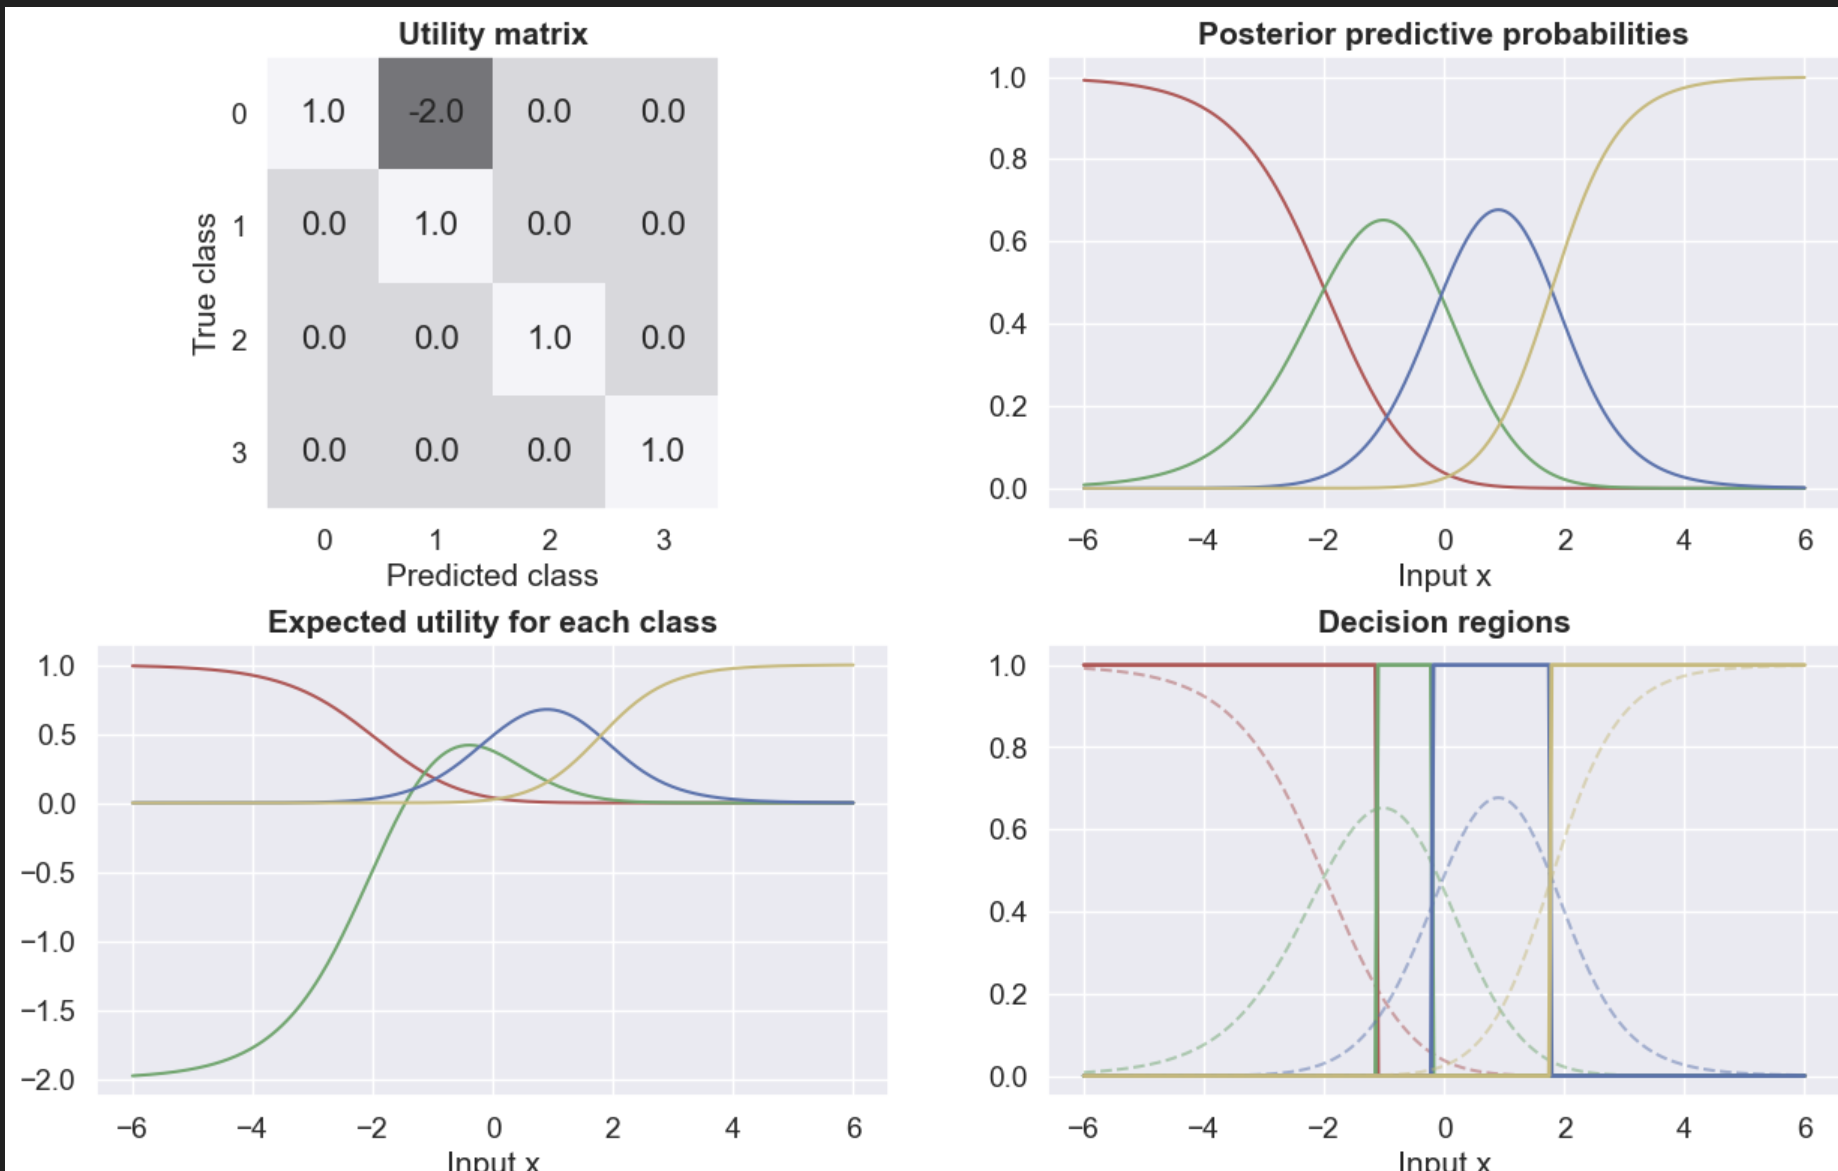


#### Expected Utility for Each Class
With utility of -2 (current image):

- The green curve dips much lower, reaching approximately -2.0 at the far left
- The crossover point between red and green curves shifts further right (closer to x = 0)
- The penalty for mistakenly predicting class 1 is more severe


#### Mathematical Implications
##### With utility of -1:
- We predict class 1 only when: P(class=1|x) - P(class=0|x) > P(class=0|x)
- This simplifies to: P(class=1|x) > 2/3 (about 0.67)


##### With utility of -2:

- We predict class 1 only when: P(class=1|x) - 2×P(class=0|x) > P(class=0|x)
- This simplifies to: P(class=1|x) > 3/4 (0.75)

This means we need even stronger evidence (higher probability) for class 1 before we're willing to predict it when the penalty is -2.

#### Decision boundary 
With utility of -2:

- The boundary would shift even further
- We would require P(class=1|x) to exceed 0.75 before predicting class 1
- The region where we predict class 1 would shrink compared to the -1 utility case

**Task 2.5**: What happens if you change the 0/1 utility function to have $U_{23} = U_{32} = 1$? [**Discussion question**]

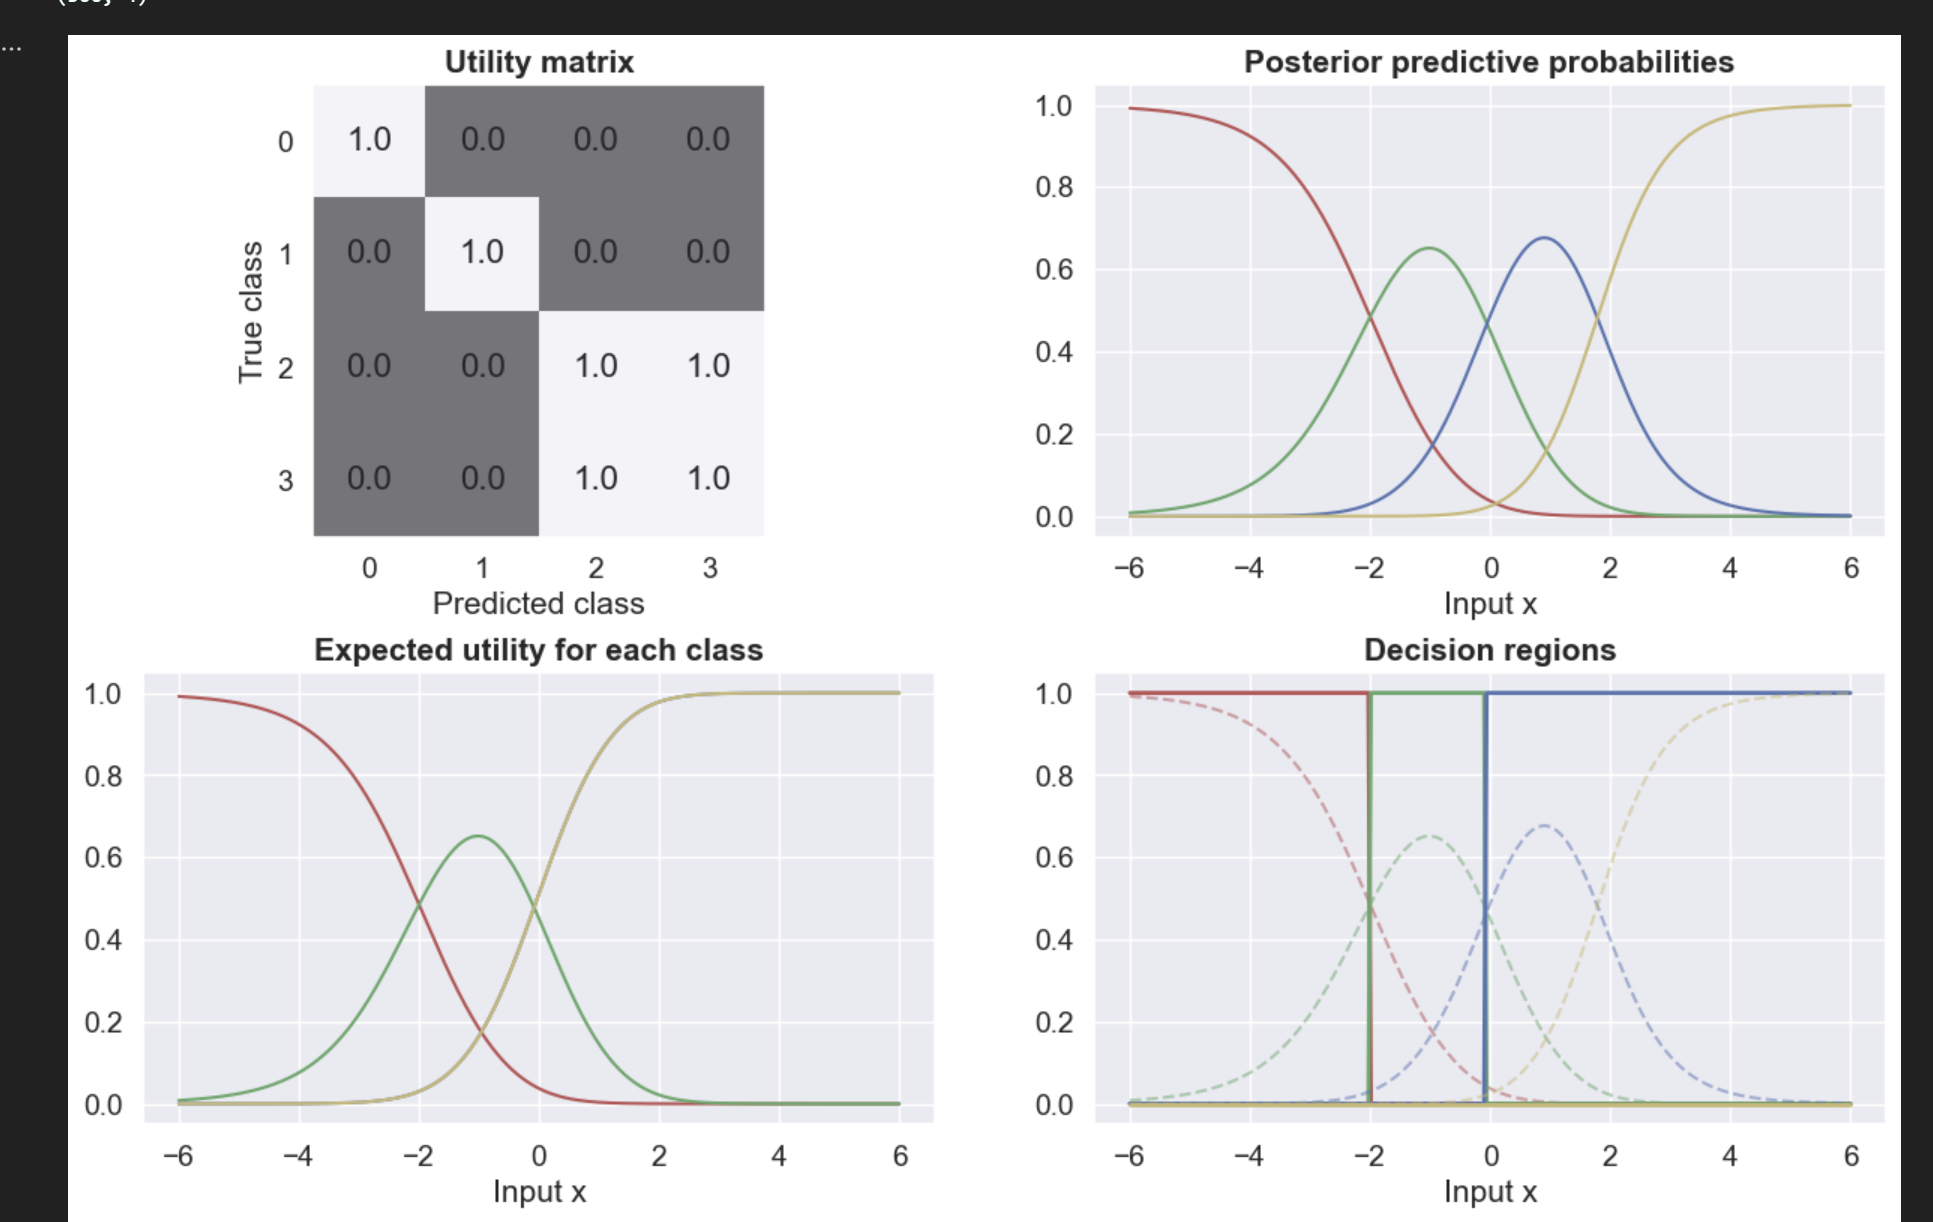

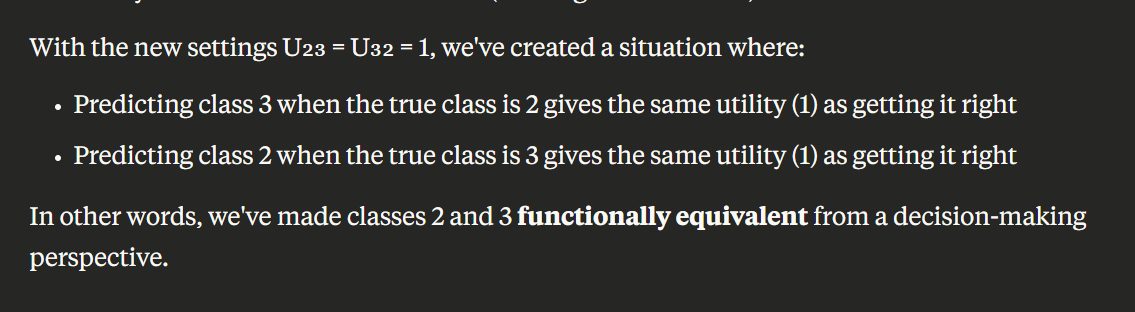

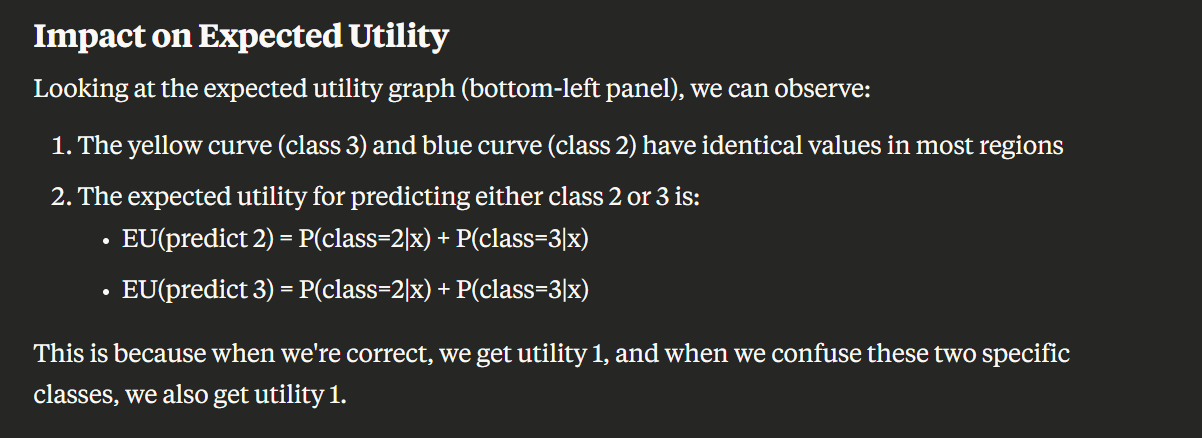

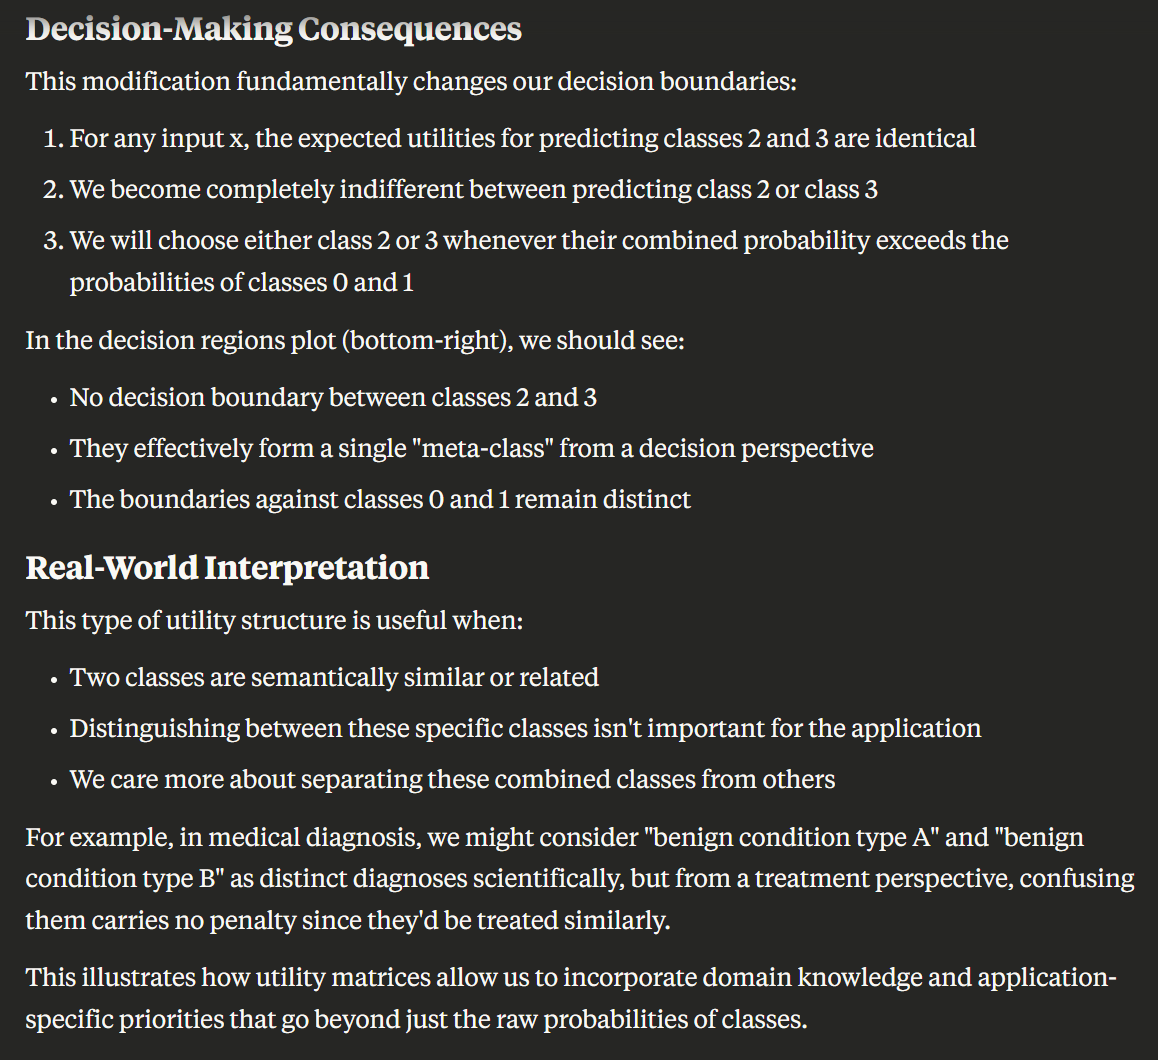

**Task 2.6**: What happens if you change the 0/1 utility function to have $U_{11} = 0$? or to $U_{11} = 0.5$? [**Discussion question**]


### 0 
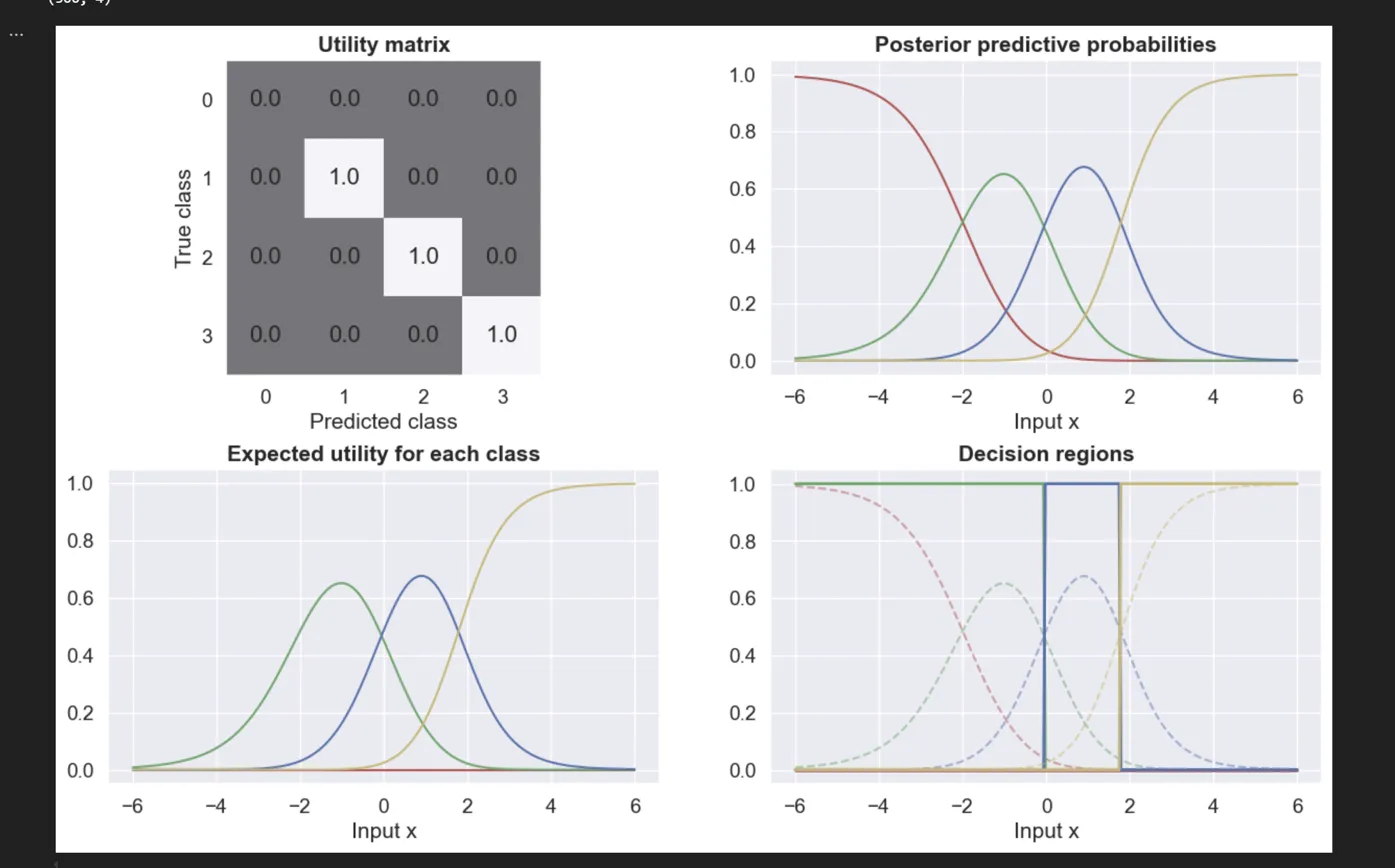
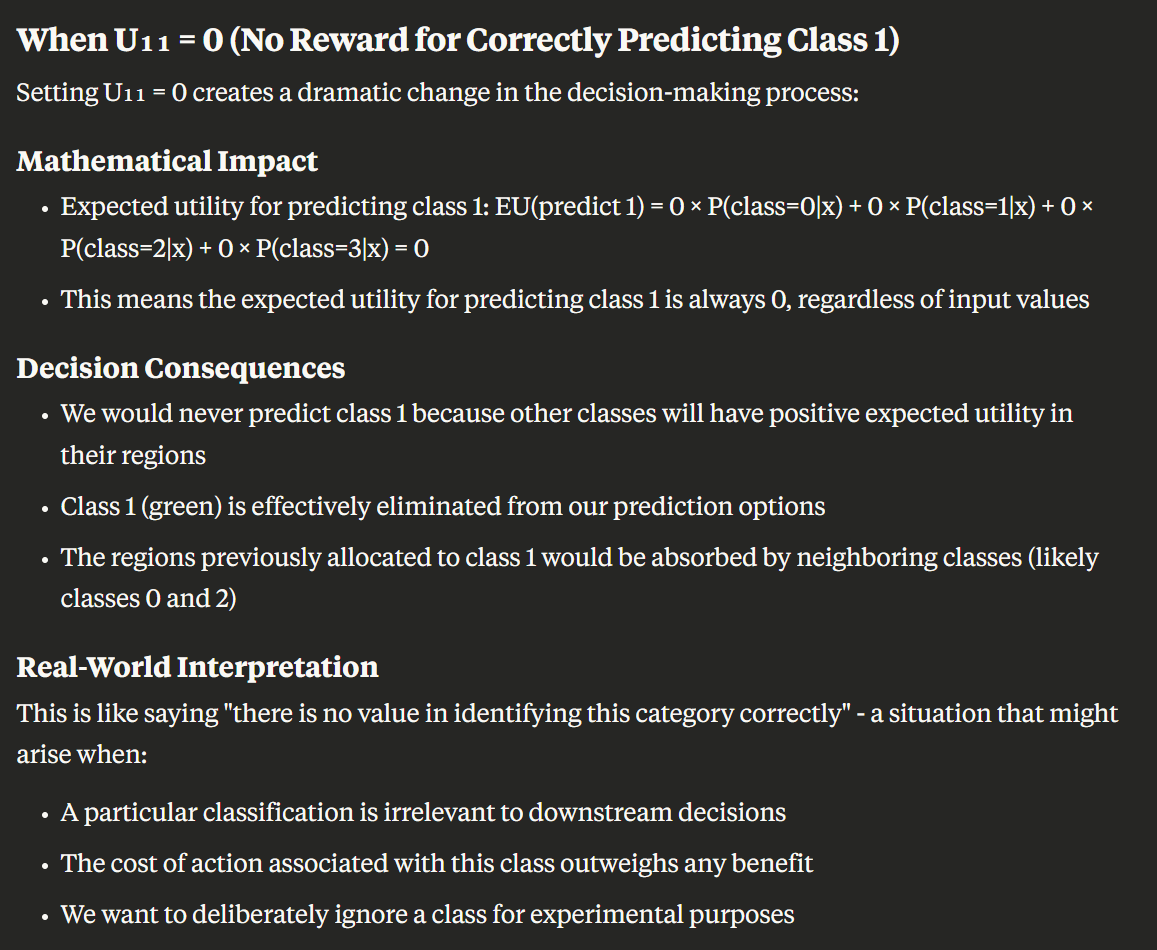
### 0.5 

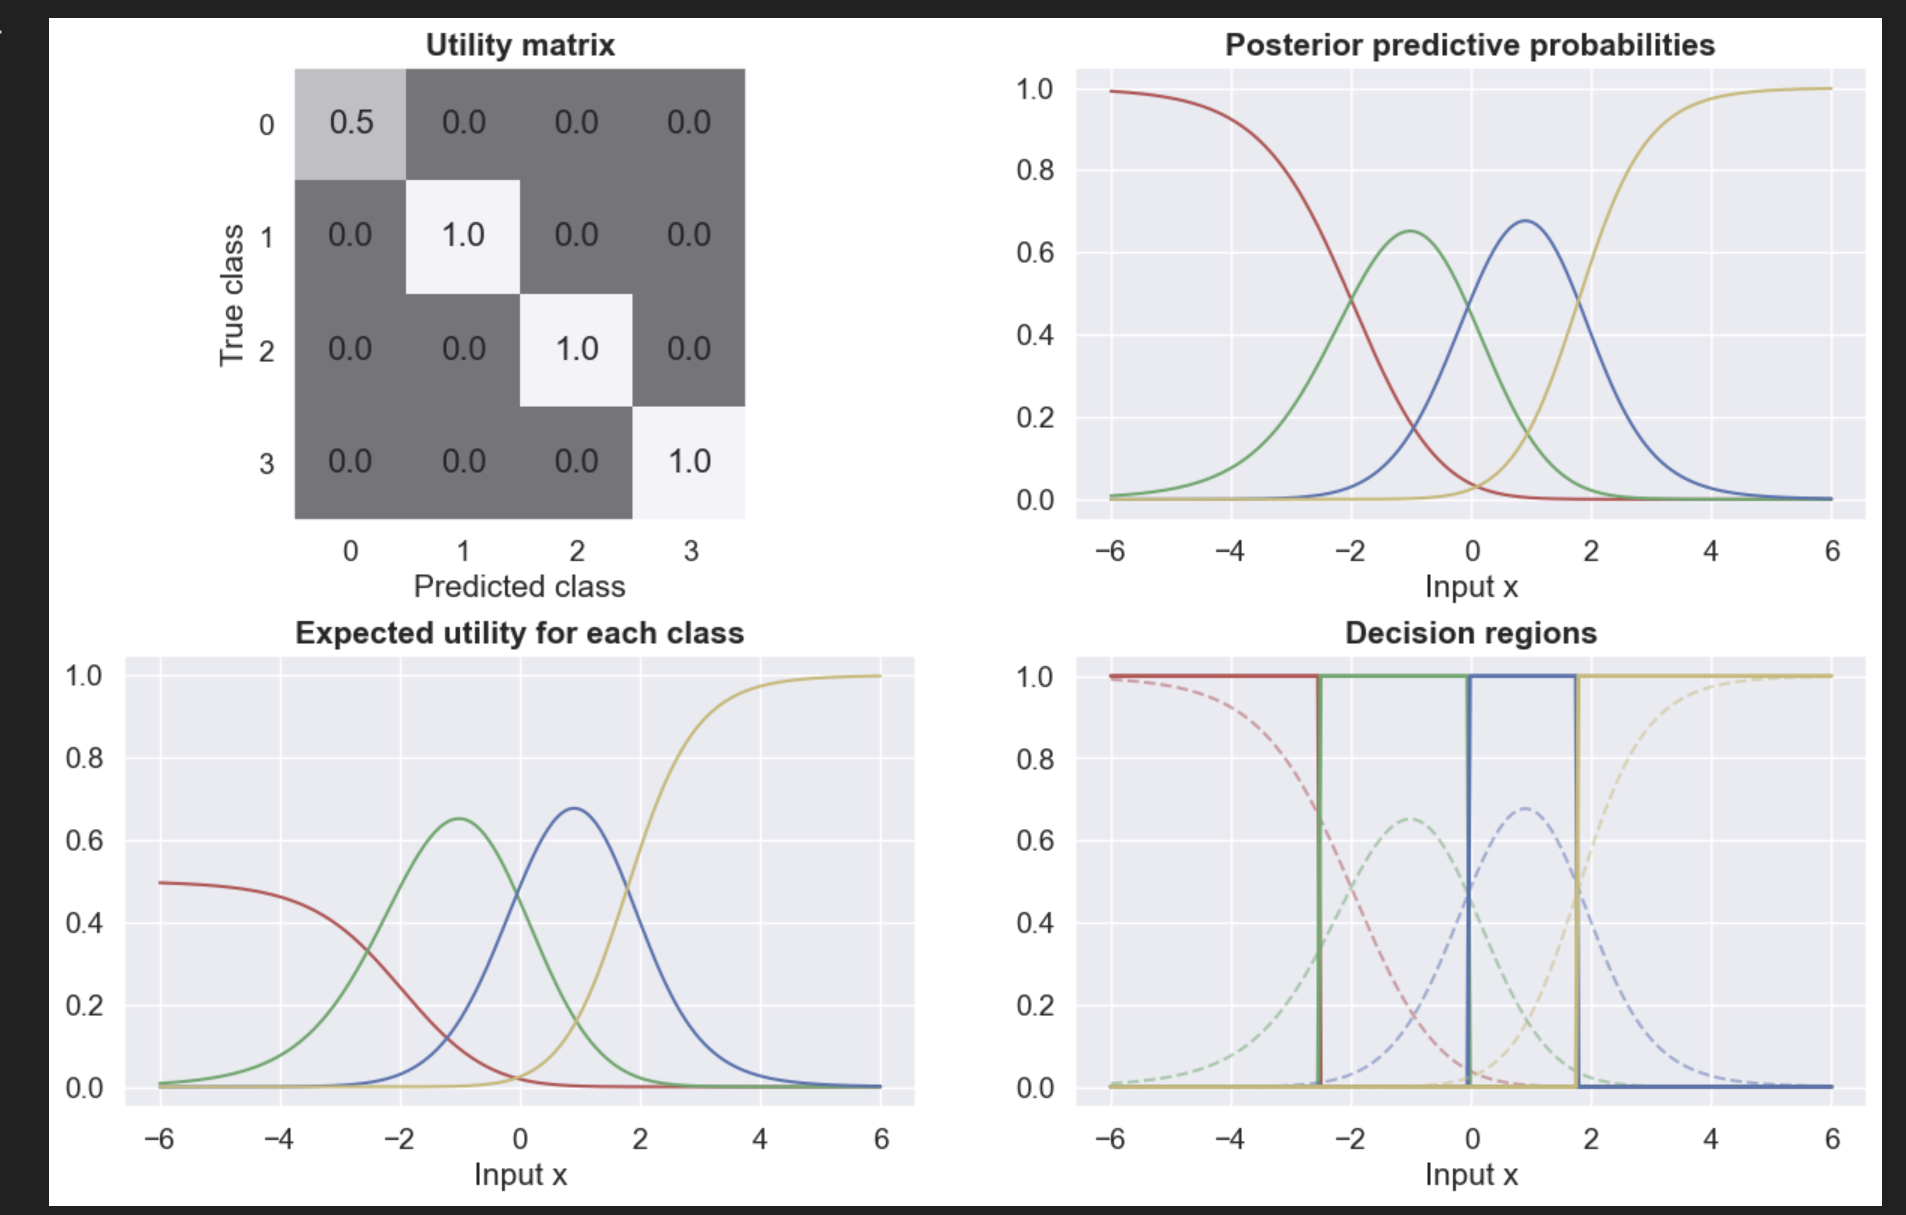

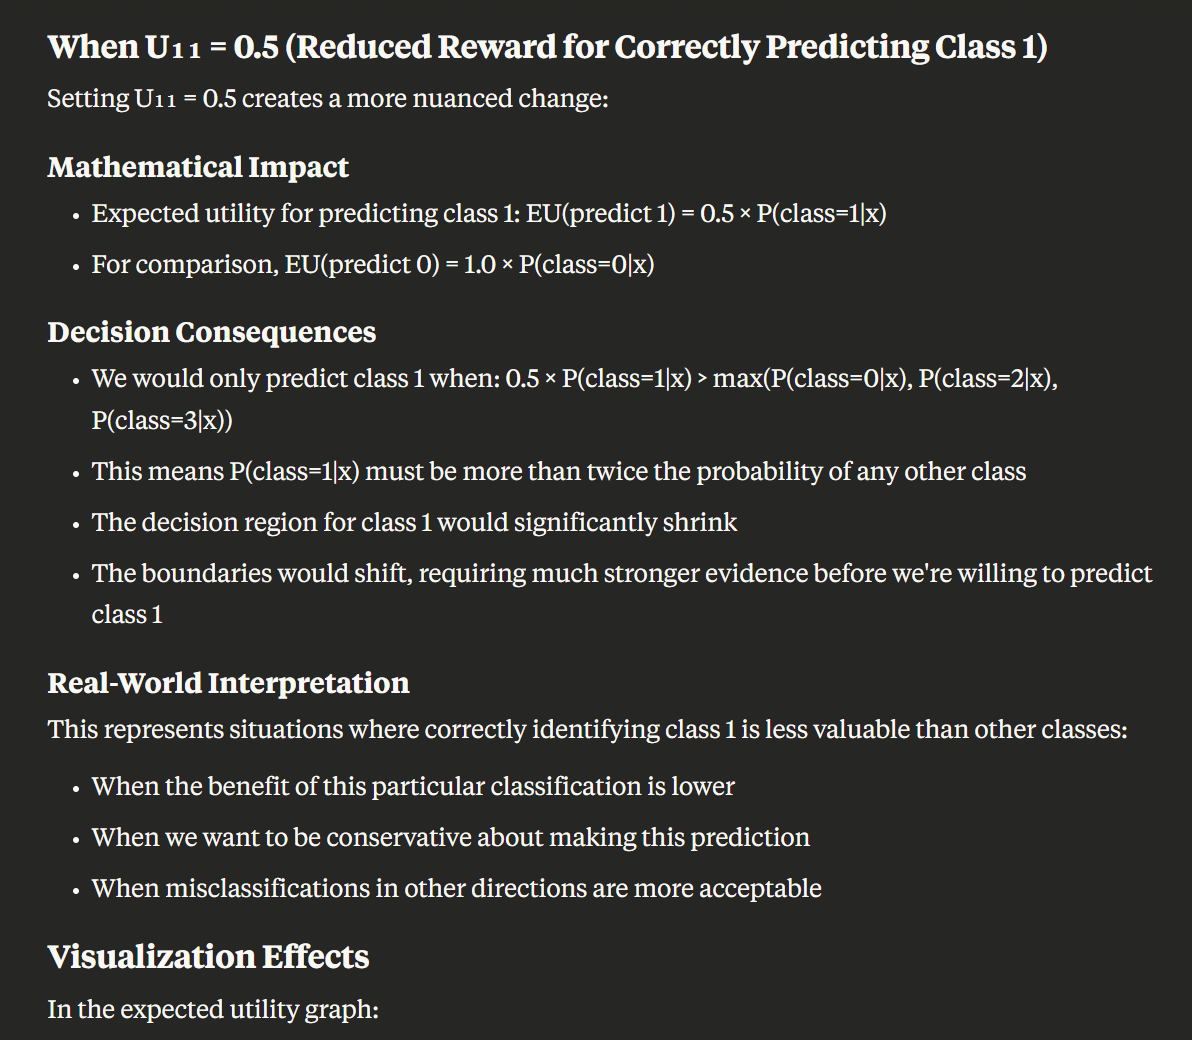
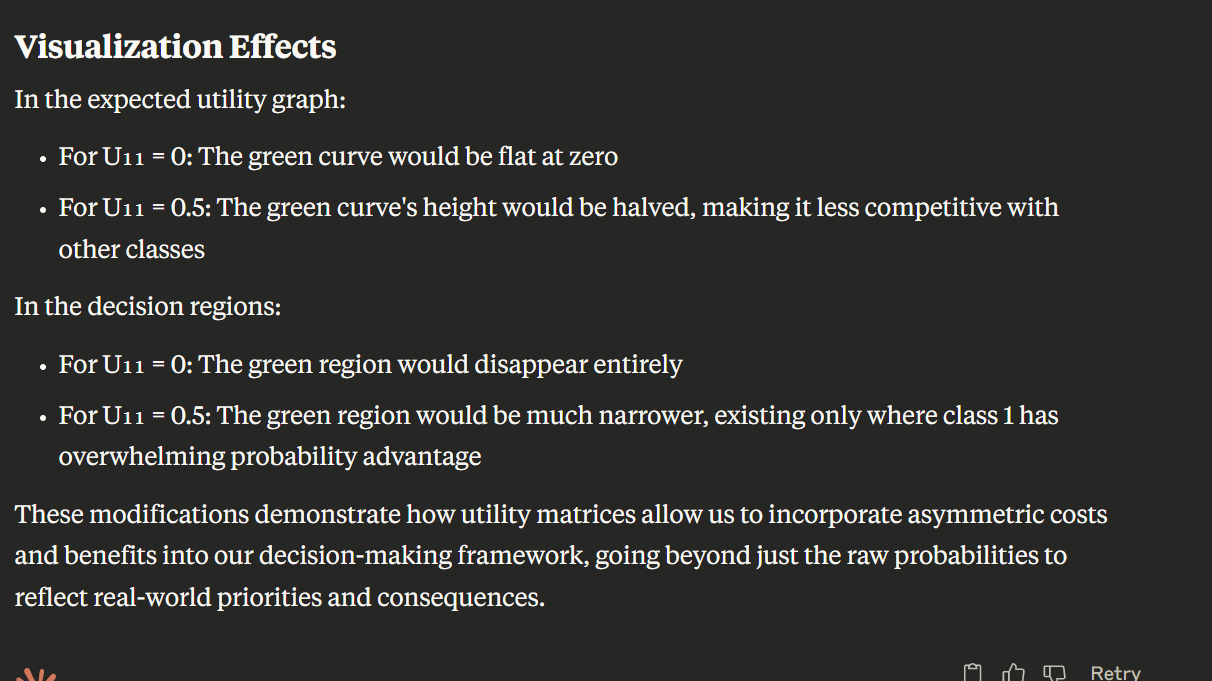


## Part 3:  Image classification

It's now time to apply the material from part 1 and part 2 to a real dataset. Specifically, we will work with a subset of the Linnaeus 5 dataset (http://chaladze.com/l5/). The original Linnaeus 5 dataset contains images of size 256x256 from 5 classes, but we will work with a subset of this dataset containing a total of 3200 images in 4 classes (dogs, birds, flowers, berries). The images have been resized to 128x128 with the sole purpose of reducing the size of the data file. 

We will use **transfer learning** and use a pretrained ResNet18-network as a **feature extractor** for the images. ResNet18 is a convolutional neural network with 18 layers, which has been trained on a huge image dataset called ImageNet. The ImageNet containes images from 1000 different classes, which means that the very last layer of the ResNet architecture is a softmax-layer with 1000 outputs. However, if we get rid of the very last layer, we can use the rest of the network as a general feature extractor for images. That is, we propagate each image through the network we can use the very last hidden layer as a 512-dimensional feature vector for the image.

The details of how this works beyond what's written above is **not** part of the curriculum of the course and therefore, we have pre-computed feature vectors for all the images for you. 

However, if you are interested in the details, you can look at the following resources:

- Code used for feature extraction [here](https://github.com/christiansafka/img2vec)
- Paper describing the ResNet architecture [here](https://arxiv.org/pdf/1512.03385.pdf)
- A Pytorch tutorial for transfer learning for vision problems [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)


Let's load the data

In [10]:
data = jnp.load('../ex7_data.npz')  # Load the dataset from a .npz file
labels = list(data['labels'])        # List of class labels (e.g., ['dog', 'bird', ...])
targets = data['targets']            # Array of ground truth class indices for all images
num_classes = data['num_classes'][()]  # Number of classes (scalar)

img_train, img_test = data['Xtrain'], data['Xtest']  # Training and test image features (each row is an image)
ytrain, ytest = data['ttrain'], data['ttest']        # Training and test labels (class indices)
train_idx = data['train_idx']        # Indices of training images in the original dataset
test_idx = data['test_idx']          # Indices of test images in the original dataset

N, D = img_train.shape               # N: number of training images, D: feature dimension (512)
Ntest = len(img_test)                # Number of test images
print(f'Number of images for training: {N}')
print(f'Number of images for test: {Ntest}')
print(f'Number of features: {D}')
print(f'Number of clases: {num_classes}')


Number of images for training: 320
Number of images for test: 2880
Number of features: 512
Number of clases: 4


.. and plot a few examples

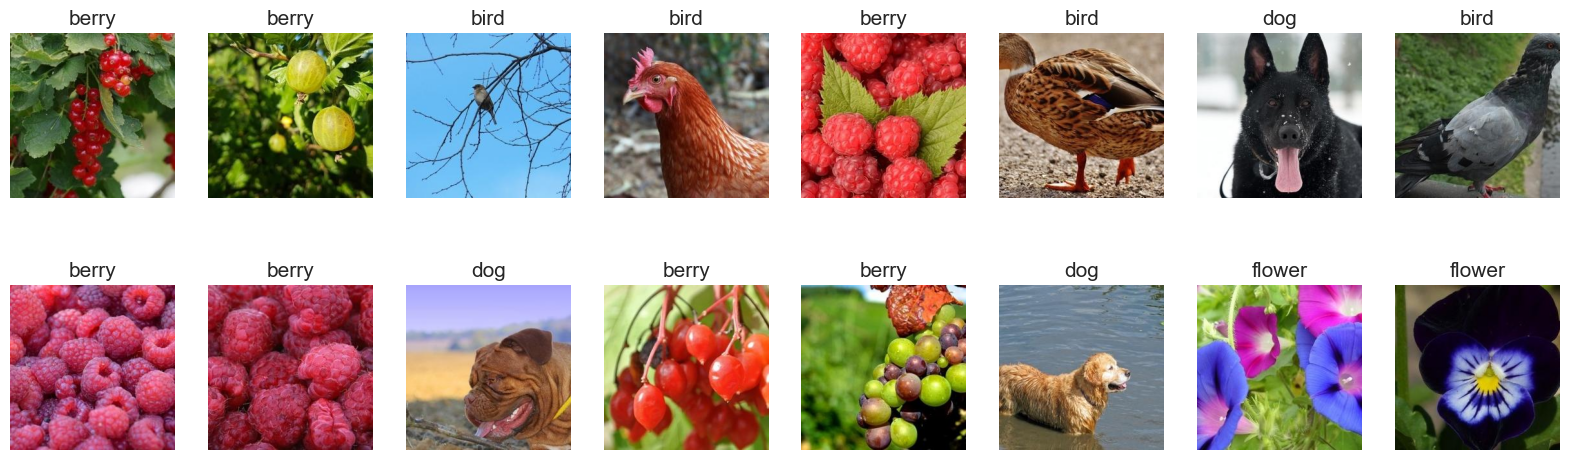

In [14]:
def show_example(ax, i):
    """ show training example i """
    
    # Get the index of the i-th training image in the original dataset
    j = train_idx[i]
    # Load the image from file
    img = Image.open('../images/%d.jpg' % j)
    # Get the class label for this image
    target = targets[j]
    # Display the image on the given axis
    ax.imshow(img)
    # Set the title to the class label
    ax.set_title(labels[int(target)])
    # Remove grid lines
    ax.grid(False)
    # Hide axis ticks
    ax.axis('off')

# Create a 2x8 grid of subplots for displaying 16 images
fig, ax = plt.subplots(2, 8, figsize=(20, 6))
# Loop over the first 16 training examples and display each one
for i in range(16):
    show_example(ax.flat[i], i)

Each image is represented using a 512-dimensional feature vector, but we will (again) reduce the dimensionality to $D = 2$ using principal component analysis (PCA) for the purpose of visualization.

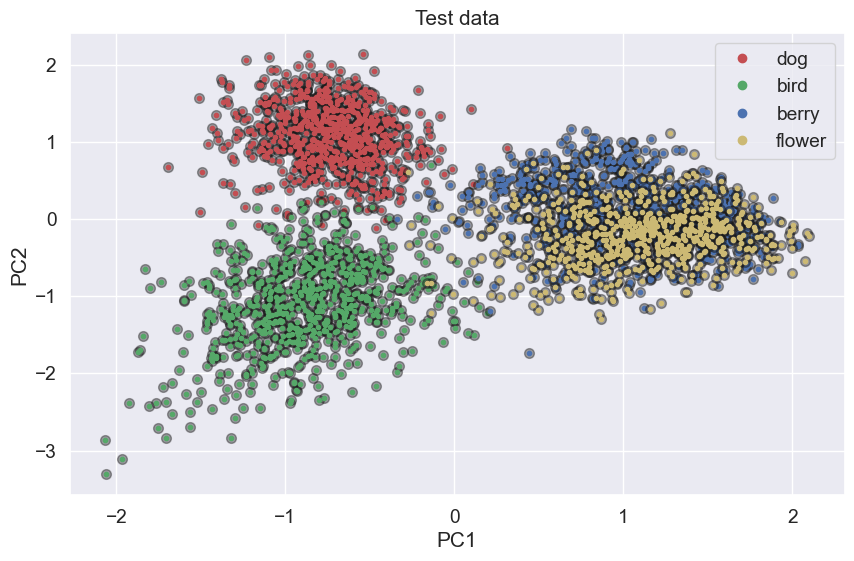

In [ ]:
# Reduce dimensionality of image features to 2D using PCA for visualization
Ztrain, Ztest = PCA_dim_reduction(img_train, img_test, num_components=2)

def plot_pca_data(ax, legend=True, alpha=1):
    # Plot the test data in PCA space, colored by class
    for i in range(num_classes):
        # Plot all test points for class i as large black dots (background)
        ax.plot(Ztest[ytest==i, 0], Ztest[ytest==i, 1], '.', color='k', markersize=14, alpha=0.4)
        # Plot all test points for class i as smaller colored dots (foreground)
        ax.plot(Ztest[ytest==i, 0], Ztest[ytest==i, 1], '.', color=colors[i], label=labels[i], markersize=6, alpha=alpha)
    if legend:
        ax.legend(markerscale=2)  # Show legend with larger marker size
    ax.set(xlabel='PC1', ylabel='PC2')  # Label axes
    ax.set_title('Test data')           # Set plot title

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))
plot_pca_data(ax);  # Plot the PCA-reduced test data


Let's  fit the model and visualize the posterior class probabilitites.

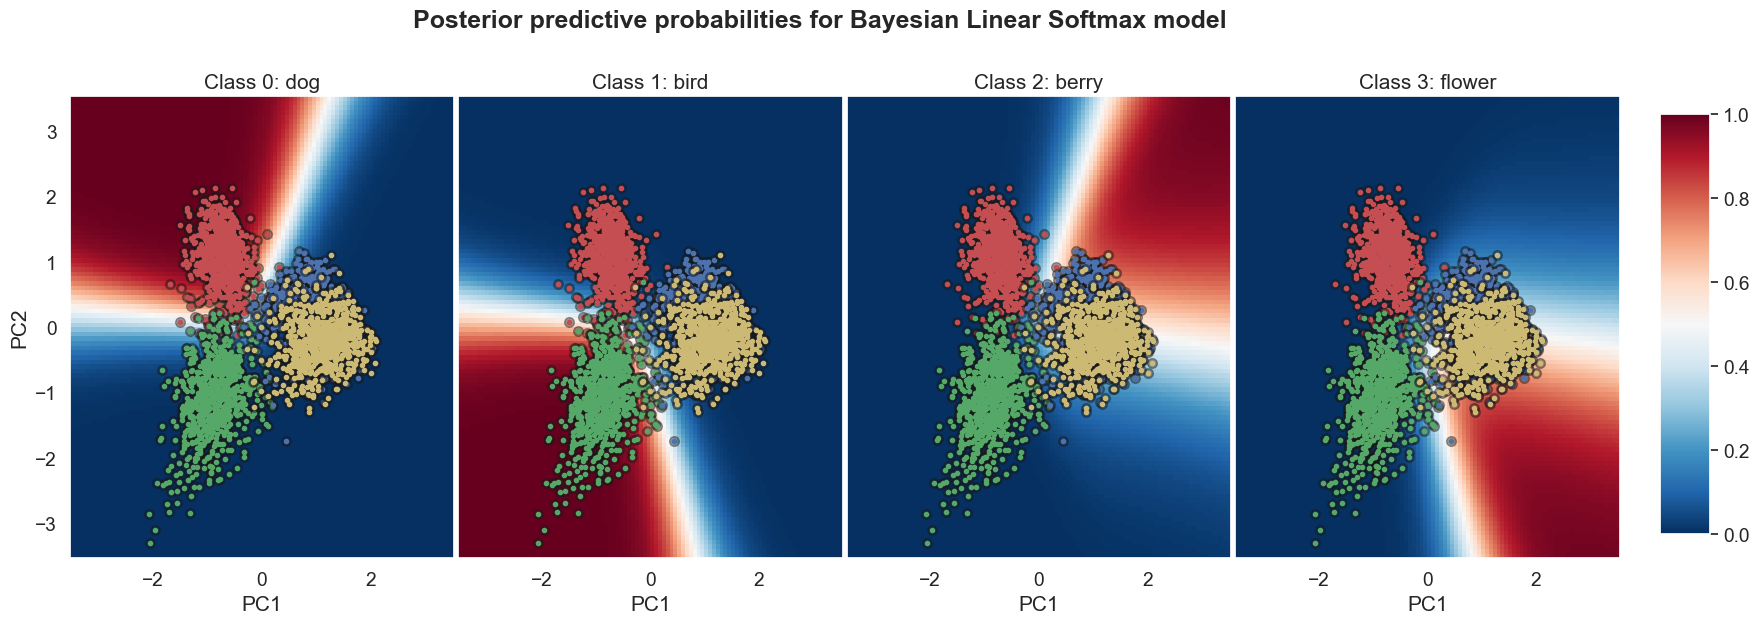

In [16]:
def visualize_regions(x_grid, posterior_class_probs, name, show_data=True):
    # Create a figure with 4 subplots (one for each class)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    for i in range(num_classes):
        # Reshape the predicted probabilities for class i to match the grid shape
        probs_reshaped = posterior_class_probs[:, i].reshape((len(x_grid), len(x_grid)))
        # Plot the probability surface for class i using pcolormesh
        im = axes[i].pcolormesh(
            x_grid, x_grid, probs_reshaped,
            cmap=plt.cm.RdBu_r, clim=(0, 1), shading='auto'
        )

        # Optionally overlay the data points in PCA space
        if show_data:
            plot_pca_data(axes[i], legend=False)
        # Set the title for each subplot to indicate the class
        axes[i].set_title('Class %d: %s' % (i, labels[i]))

        # Remove y-axis labels for all but the first subplot for cleaner appearance
        if i > 0:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel('')

    # Adjust layout and add a colorbar to the right of the plots
    fig.subplots_adjust(right=0.9, wspace=0.01)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # Add a main title to the figure
    fig.suptitle(name, fontweight='bold', y=1.025)

# Prepare training and test data with intercept term
X_train, X_test = design_matrix(Ztrain), design_matrix(Ztest)

# Prepare a grid in PCA space for visualization
x_grid = jnp.linspace(-3.5, 3.5, 100)   # 
XX1, XX2 = jnp.meshgrid(x_grid, x_grid) # shapes (100, 100)
Xp = jnp.column_stack((XX1.ravel(), XX2.ravel()))  # shapes (10000, 2)

X_pred = design_matrix(Xp)                      # shapes (10000, 3)

# Fit the Bayesian linear softmax classifier on the training data
model = BayesianLinearSoftmax(X_train, ytrain)    # shapes (200, 3)
# Compute posterior predictive probabilities for each grid point
p_pred = model.predict_y(X_pred)                 # shapes (10000, 4)

# Visualize the posterior class probabilities for each class
visualize_regions(x_grid, p_pred, 'Posterior predictive probabilities for Bayesian Linear Softmax model')

**Task 3.1**: Compute predictions (wrt. the 0/1-utility function) and compute the accuracy for the training and test set.



In [19]:
def compute_accuracy(y_true, y_pred):
    """
    Computes the classification accuracy.

    Equation:
        accuracy = (number of correct predictions) / (total number of predictions)
                 = mean(y_true == y_pred)

    Inputs:
        y_true: array-like, shape (N,)
            True class labels.
        y_pred: array-like, shape (N,)
            Predicted class labels.

    Output:
        accuracy: float
            Proportion of correct predictions.
    """
    return jnp.mean(y_true.ravel() == y_pred.ravel())

# Evaluate posterior predictive class probabilities for training and test set
# Uses: model.predict_y (BayesianLinearSoftmax.predict_y)
# Inputs: X_train, X_test (feature matrices)
# Outputs: p_train, p_test (arrays of shape [num_samples, num_classes])
p_train = model.predict_y(X_train)
p_test = model.predict_y(X_test)

# Classify using 0/1 utility function (i.e., pick class with highest probability)
# Uses: jnp.argmax
# Inputs: p_train, p_test (posterior predictive probabilities)
# Outputs: ytrain_hat, ytest_hat (predicted class indices)
ytrain_hat = jnp.argmax(p_train, axis=1) 
ytest_hat = jnp.argmax(p_test, axis=1)

# Compute and print accuracy for training and test set
# Uses: compute_accuracy (defined above)
# Inputs: ytrain, ytrain_hat, ytest, ytest_hat
# Outputs: accuracy values (float)
print('Accuracy training:\t%3.2f' % compute_accuracy(ytrain, ytrain_hat))
print('Accuracy test:\t\t%3.2f' % compute_accuracy(ytest, ytest_hat))

Accuracy training:	0.85
Accuracy test:		0.80


**Task 3.2**: Compute and plot the **entropy** and **confidence** for the predictions in the plot above. In which areas of the input space is this model most uncertain about the class label?

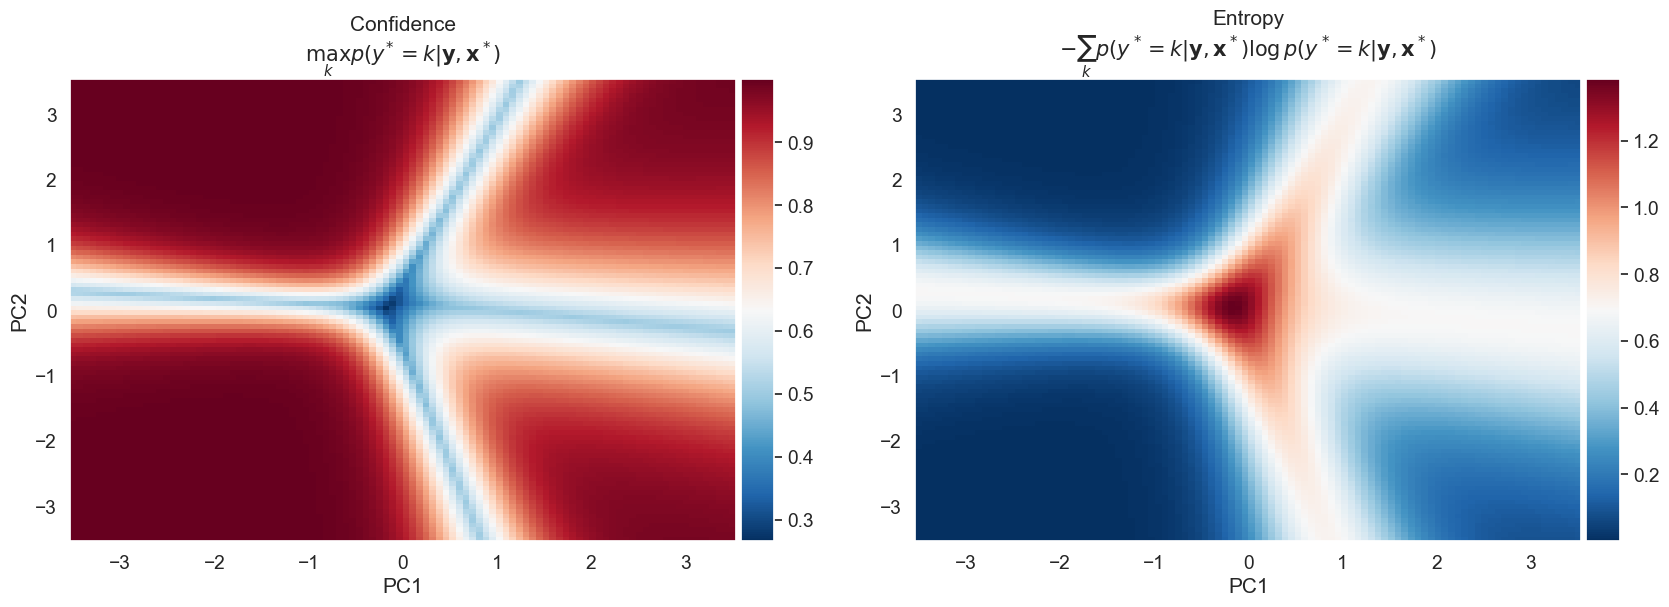

In [23]:
def confidence(p):
    """
    Computes the confidence for each predictive distribution.

    The confidence is defined as the maximum predicted probability for each sample:
        confidence(x^*) = max_k p(y^*=k | x^*, D)
    where D is the training data.

    Parameters
    ----------
    p : jax.numpy.ndarray
        Posterior predictive probabilities for each sample and class.
        Shape: (N, K), where N is the number of prediction points and K is the number of classes.

    Returns
    -------
    conf : jax.numpy.ndarray
        Confidence for each prediction point.
        Shape: (N,)

    Equation
    --------
    conf_n = max_k p_{n,k}
    """
    return jnp.max(p, axis=1)  # Shape: (N,)


def entropy(p):
    """
    Computes the predictive entropy for each predictive distribution.

    The entropy measures the uncertainty of the predictive distribution:
        entropy(x^*) = -sum_k p(y^*=k | x^*, D) * log(p(y^*=k | x^*, D))

    Parameters
    ----------
    p : jax.numpy.ndarray
        Posterior predictive probabilities for each sample and class.
        Shape: (N, K), where N is the number of prediction points and K is the number of classes.

    Returns
    -------
    ent : jax.numpy.ndarray
        Predictive entropy for each prediction point.
        Shape: (N,)

    Equation
    --------
    ent_n = -sum_k p_{n,k} * log(p_{n,k})
    """
    return -jnp.sum(p * jnp.log(p), axis=1)  # Shape: (N,)


# Visualization of confidence and entropy over the PCA grid
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Compute confidence and entropy for each grid point
# p_pred: shape (num_grid_points, num_classes)
conf = confidence(p_pred)  # Shape: (num_grid_points,)
ent = entropy(p_pred)      # Shape: (num_grid_points,)

# Reshape to (len(x_grid), len(x_grid)) for plotting as 2D grid
conf_grid = conf.reshape((len(x_grid), len(x_grid)))
ent_grid = ent.reshape((len(x_grid), len(x_grid)))

# Plot confidence
im0 = ax[0].pcolormesh(
    x_grid, x_grid, conf_grid,
    shading='auto', cmap=plt.cm.RdBu_r
)
ax[0].set(
    xlabel='PC1', ylabel='PC2',
    title='Confidence\n$\\max_k p(y^*=k|\\mathbf{y}, \\mathbf{x}^*)$'
)
add_colorbar(im0, fig, ax[0])

# Plot entropy
im1 = ax[1].pcolormesh(
    x_grid, x_grid, ent_grid,
    shading='auto', cmap=plt.cm.RdBu_r
)
ax[1].set(
    xlabel='PC1', ylabel='PC2',
    title='Entropy\n$-\\sum_k p(y^*=k|\\mathbf{y}, \\mathbf{x}^*) \\log p(y^*=k|\\mathbf{y}, \\mathbf{x}^*)$'
)
add_colorbar(im1, fig, ax[1])


**Task 3.3**: Compute the average confidence for the training set and test set and accuracy results



In [26]:
# Compute confidence for each sample
conf_train = confidence(p_train)  # shape: (N_train,)
conf_test = confidence(p_test)    # shape: (N_test,)

# Compute average confidence
avg_conf_train = jnp.mean(conf_train)
avg_conf_test = jnp.mean(conf_test)

# Compute accuracy

print('Avg. confidence training: %3.2f' % avg_conf_train)
print('Avg. confidence test: %3.2f' % avg_conf_test)

Avg. confidence training: 0.79
Avg. confidence test: 0.76


## Part 4:  Making decisions with a reject option

Next, we will investigate how to make decisions with a **reject** option, meaning we avoid to making any decisions if the confidence is below a specified threshold $p_{\text{reject}}$.

Text(0.5, 1.0, 'Decision regions w. reject for Bayesian Linear Softmax')

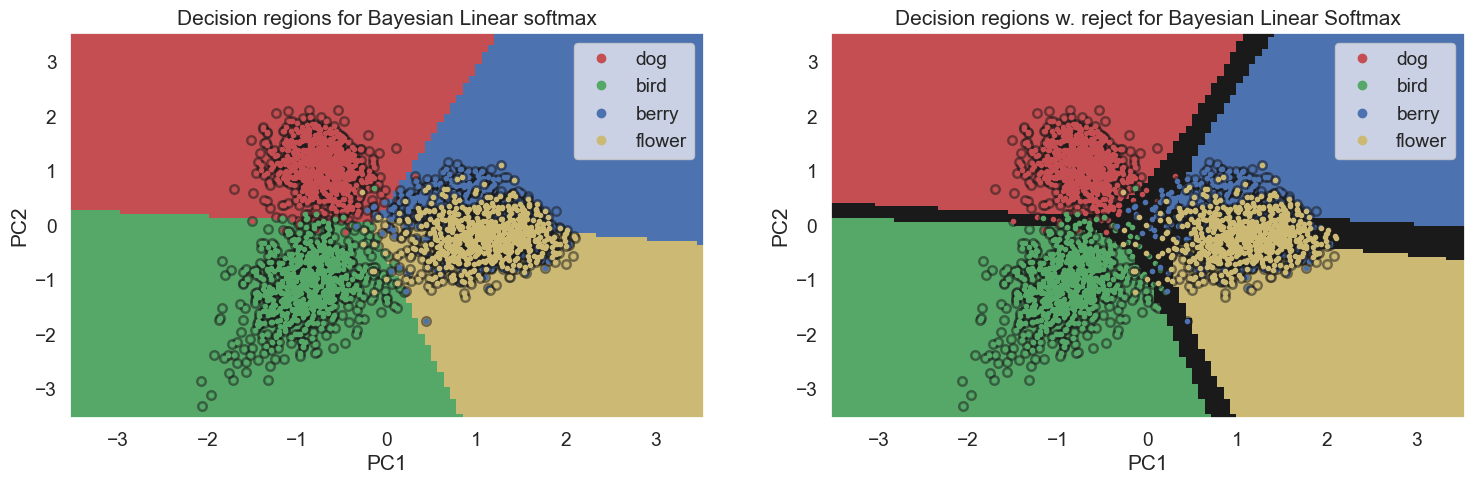

In [31]:
# specify reject threshold
p_reject = 0.6  # If confidence is below this value, we reject making a decision

# compute decisions under 0/1-utility function and reshape to grid
# For each grid point, pick the class with the highest predicted probability
decisions = jnp.argmax(p_pred, axis=1).reshape((len(x_grid), len(x_grid)))

# identify reject regions
# Compute the confidence (maximum predicted probability) for each grid point
p_pred_confidence = confidence(p_pred)  # shape: (num_grid_points,)

# Create a mask for the reject region:
# True (1) if confidence >= p_reject (i.e., we make a decision)
# False (0) if confidence < p_reject (i.e., we reject)
reject_region_bls = 1.0 * jnp.logical_not((p_pred_confidence < p_reject).reshape((len(x_grid), len(x_grid))))

# This mask has value 1 where we make a decision, and 0 where we reject

# Set decisions to 0 (black) in the reject region, otherwise to class index + 1 (so 0 is reserved for reject)
# This way, class 0 is mapped to 1, class 1 to 2, etc., and 0 means "reject"
decisions_with_reject = (decisions + 1) * reject_region_bls

# visualize
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot decision regions without reject option
plot_pca_data(axes[0])
axes[0].pcolormesh(
    x_grid, x_grid, decisions,
    cmap=ListedColormap(colors), alpha=1, shading='auto'
)
axes[0].set_title('Decision regions for Bayesian Linear softmax')

# Plot decision regions with reject option
plot_pca_data(axes[1])
axes[1].pcolormesh(
    x_grid, x_grid, decisions_with_reject,
    cmap=ListedColormap(['k'] + colors),  # 'k' for reject region (black)
    shading='auto'
)
axes[1].set_title('Decision regions w. reject for Bayesian Linear Softmax')


**Task 4.1**: Explain what you see in the figure above - relate the **reject region** in black to the confidence plot above [**Discussion question**]

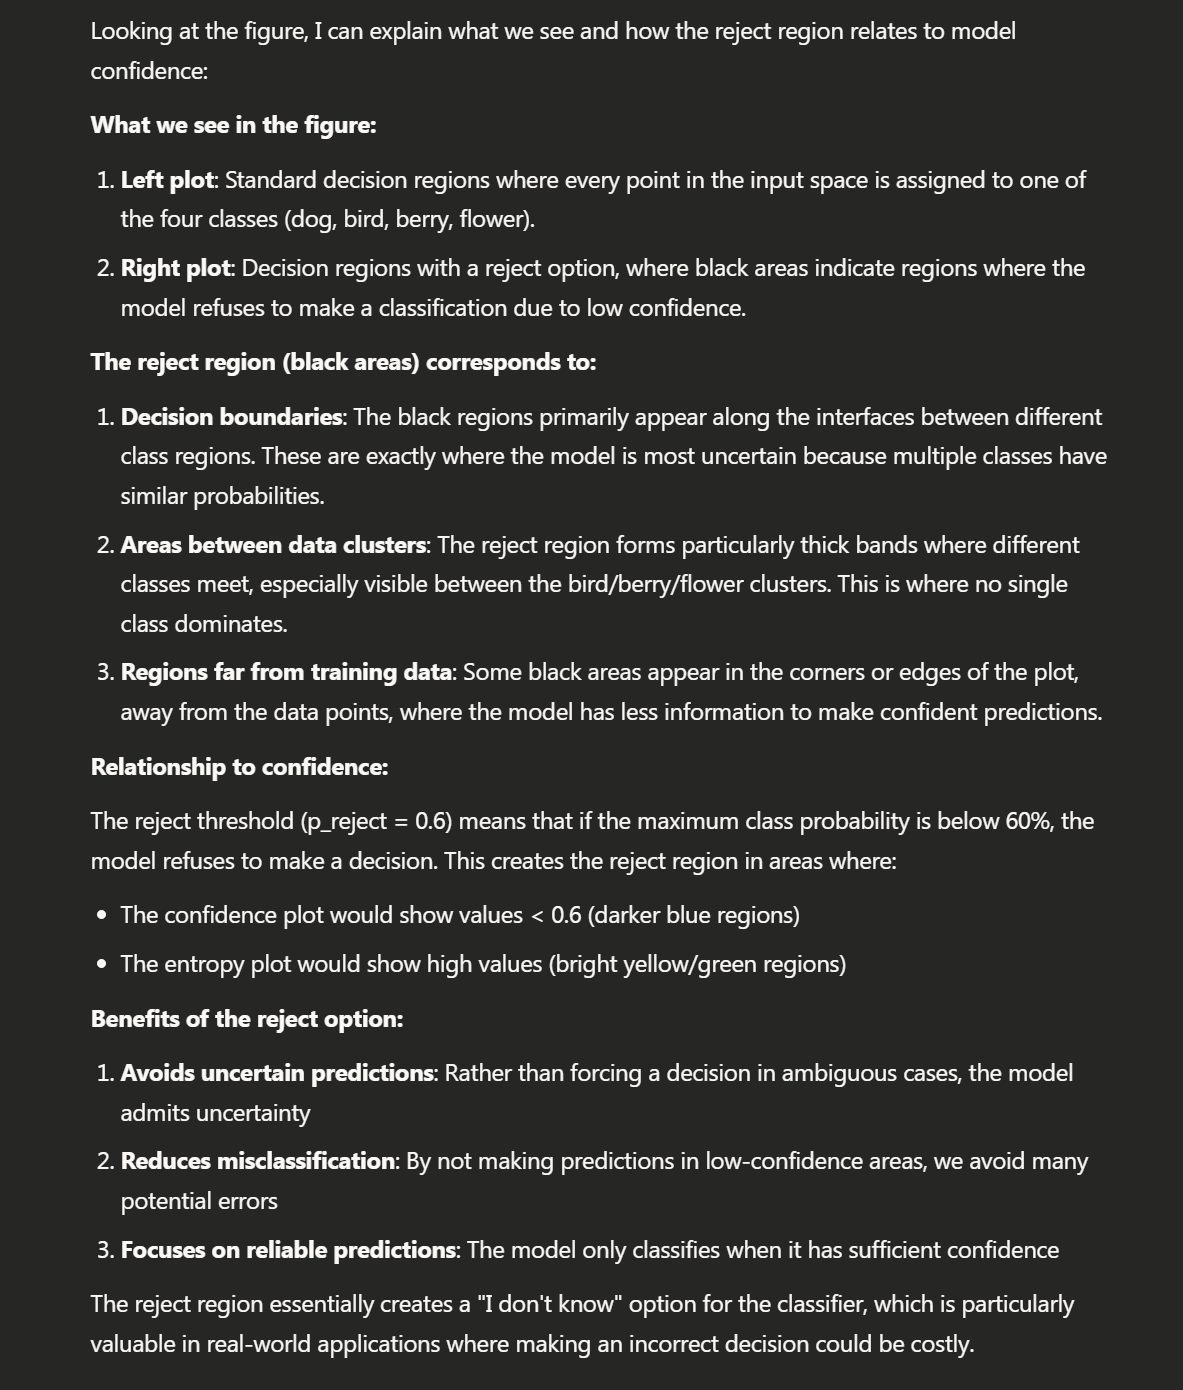



**Task 4.2**: What happens to the reject region if you increase or decrease the reject threshold?  [**Discussion question**]

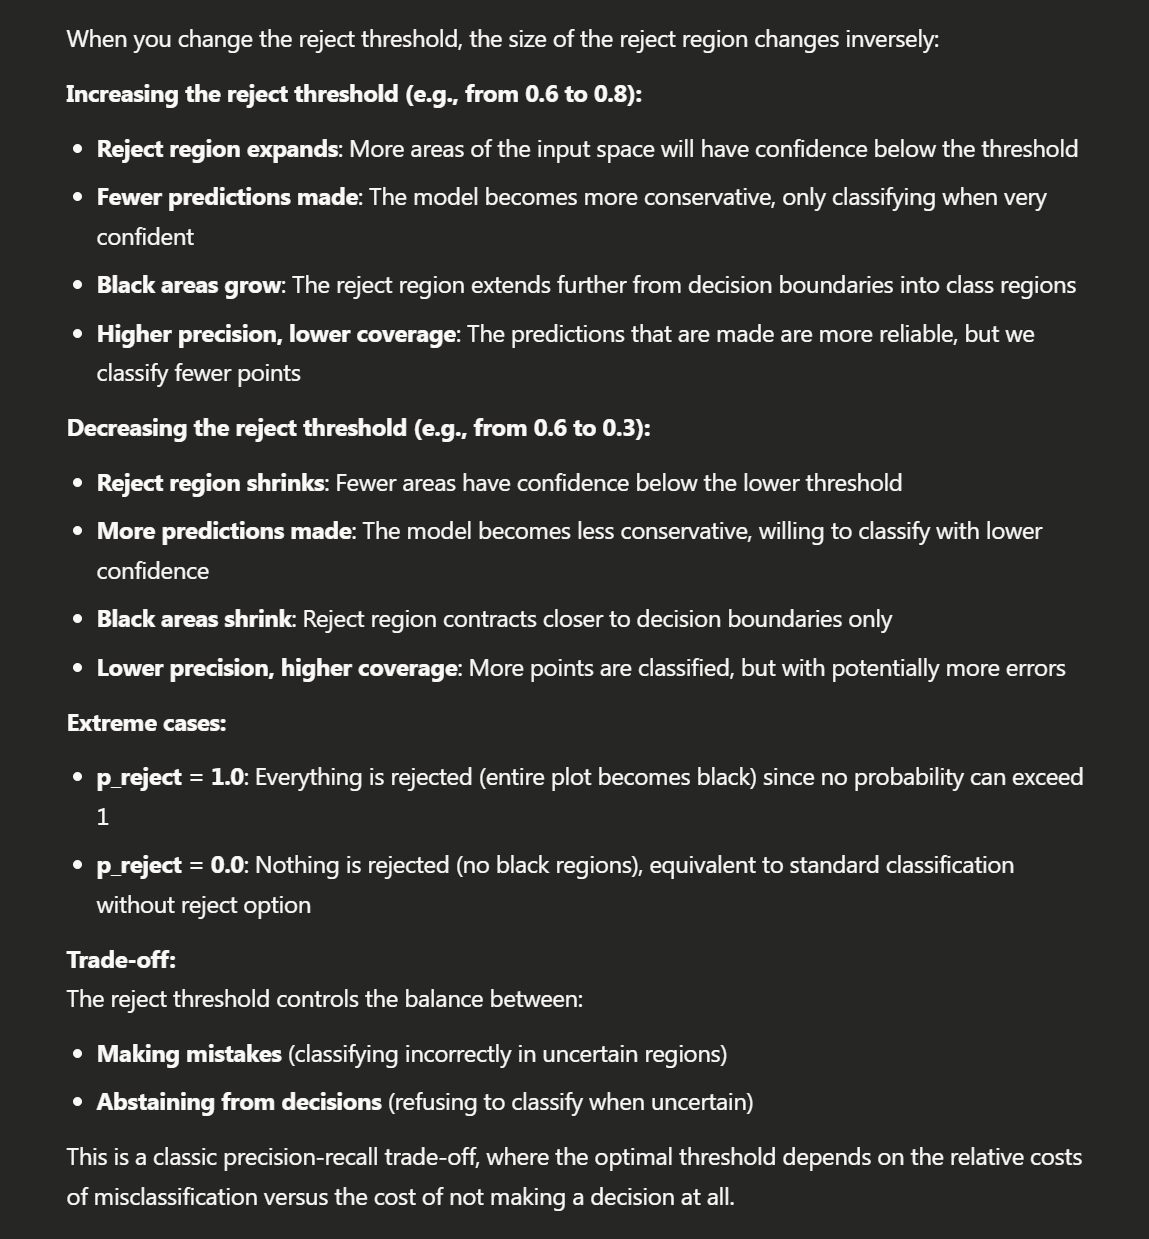

**Task 4.3**: How many percent of the samples in the test set are rejected with $p_{\text{reject}} = 0.6$?


In [39]:
# Compute boolean masks for rejected and kept test samples based on confidence threshold
# test_set_reject_idx: True for samples with confidence < p_reject (rejected)
# test_set_keep_idx:   True for samples with confidence >= p_reject (kept)
test_set_reject_idx = confidence(p_test) < p_reject 
test_set_keep_idx  = confidence(p_test) >= p_reject

# Calculate the fraction of rejected samples:
# jnp.mean(test_set_reject_idx) gives the proportion of True values (i.e., rejected samples)
# Multiply by 100 to get percentage
fraction_rejected = jnp.mean(test_set_reject_idx) * 100

# Similarly, calculate the fraction of kept samples
fraction_kept = jnp.mean(test_set_keep_idx) * 100

# Print the results with detailed explanation
print(f"Fraction of test samples rejected (confidence < {p_reject}): {fraction_rejected:.2f}%")
print(f"Fraction of test samples kept (confidence >= {p_reject}): {fraction_kept:.2f}%")


Fraction of test samples rejected (confidence < 0.6): 28.23%
Fraction of test samples kept (confidence >= 0.6): 71.77%


**Task 4.4**: What is the test accuracy rate for the samples in the test set, which are not rejected?



In [40]:
# Select the true labels of the test samples that are NOT rejected (i.e., confidence >= p_reject)
# ytest: array of true class labels for all test samples, shape (N_test,)
# test_set_keep_idx: boolean mask, True for samples with confidence >= p_reject, shape (N_test,)
y_test_keep = ytest[test_set_keep_idx]

# Select the predicted class probabilities for the kept test samples
# p_test: posterior predictive probabilities for all test samples, shape (N_test, num_classes)
# ptest_keep: shape (N_kept, num_classes), where N_kept is the number of kept samples
ptest_keep = p_test[test_set_keep_idx]

# For each kept test sample, predict the class with the highest posterior probability
# jnp.argmax(ptest_keep, axis=1): returns the index (class) with the highest probability for each sample
# yest_keep_hat: predicted class labels for kept test samples, shape (N_kept,)
yest_keep_hat = jnp.argmax(ptest_keep, axis=1)  

# Compute and print the accuracy for the kept test samples
# compute_accuracy(y_test_keep, yest_keep_hat): returns the fraction of correct predictions among kept samples
print('Accuracy test (kept):\t%3.2f' % compute_accuracy(y_test_keep, yest_keep_hat))

Accuracy test (kept):	0.89


**Task 4.5**: If we were to make a decision for the test samples in the reject region, what would the accuracy rate be? 



In [42]:
# Select the true labels of the test samples that are rejected (i.e., confidence < p_reject)
# ytest: array of true class labels for all test samples, shape (N_test,)
# test_set_reject_idx: boolean mask, True for samples with confidence < p_reject, shape (N_test,)
ytest_reject = ytest[test_set_reject_idx]

# Select the predicted class probabilities for the rejected test samples
# p_test: posterior predictive probabilities for all test samples, shape (N_test, num_classes)
# ptest_reject: shape (N_reject, num_classes), where N_reject is the number of rejected samples
ptest_reject = p_test[test_set_reject_idx]

# For each rejected test sample, predict the class with the highest posterior probability
# jnp.argmax(ptest_reject, axis=1): returns the index (class) with the highest probability for each sample
# ytest_reject_hat: predicted class labels for rejected test samples, shape (N_reject,)
ytest_reject_hat = jnp.argmax(ptest_reject, axis=1)

# Compute and print the accuracy for the rejected test samples
# compute_accuracy(ytest_reject, ytest_reject_hat): returns the fraction of correct predictions among rejected samples
print('Accuracy for rejected samples:\t\t%3.2f' % compute_accuracy(ytest_reject, ytest_reject_hat))

Accuracy for rejected samples:		0.58



**Task 4.6**: Instead, if the reject option, implement the following utility function and plot the corresponding decision boundaries:

- Utility of 1 for correctly classifying dogs, birds, and flowers
- Utility of 2 for correctly classifying berries
- Utility of 0 for all misclassifications



(4, 4)
(10000, 4)


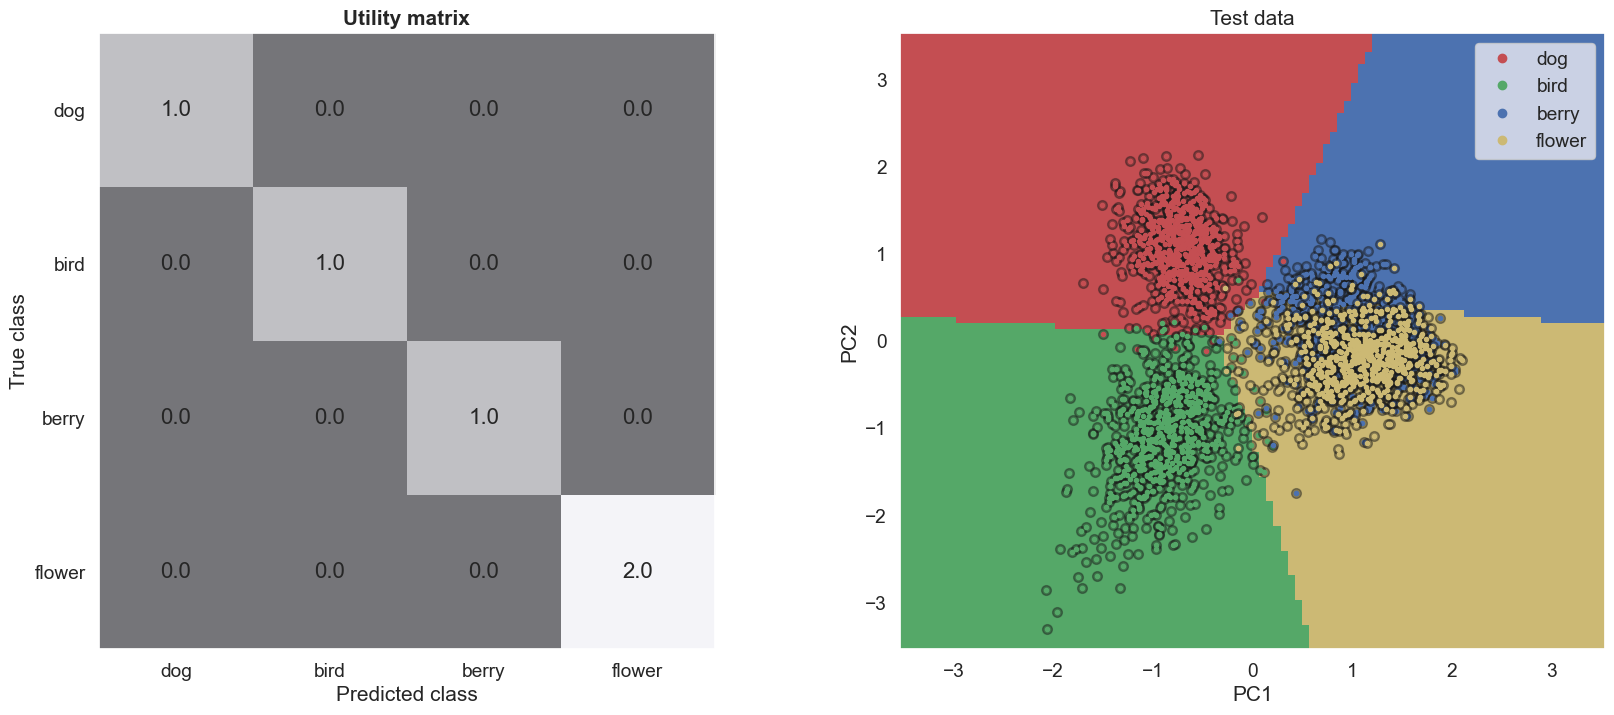

In [43]:
# Create a utility matrix for 4 classes (dogs, birds, flowers, berries)
# - Utility of 1 for correct classification of classes 0, 1, 2 (diagonal entries)
# - Utility of 2 for correct classification of class 3 (berries, diagonal entry)
# - Utility of 0 for all misclassifications (off-diagonal entries)

U = jnp.zeros((num_classes, num_classes))  # Start with all zeros

# Set utility 1 for correct classification of dogs, birds, flowers (classes 0, 1, 2)
U = U.at[0, 0].set(1)  # dogs
U = U.at[1, 1].set(1)  # birds
U = U.at[2, 2].set(1)  # flowers

# Set utility 2 for correct classification of berries (class 3)
U = U.at[3, 3].set(2)  # berries

# Compute the expected utility for each class at each grid point
# p_pred: shape (num_grid_points, num_classes)
# U: shape (num_classes, num_classes)
# Result: expected_utility: shape (num_grid_points, num_classes)
expected_utility = compute_expected_utility(U, p_pred)

# For each grid point, choose the class with the highest expected utility
# decisions: shape (num_grid_points,)
decisions = jnp.argmax(expected_utility, axis=1).reshape((len(x_grid), len(x_grid)))

# Plot the utility matrix and the resulting decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize the utility matrix
# axes[0]: show the utility matrix with class labels
visualize_utility(axes[0], U, labels=labels)

# Visualize the decision regions in PCA space
# axes[1]: show the decision boundaries for the utility function above
# Use a ListedColormap for class colors
axes[1].pcolormesh(
    x_grid, x_grid, decisions,
    cmap=ListedColormap(colors), alpha=1, shading='auto'
)
axes[1].set_title('Decision regions for custom utility (berries=2, others=1)')
plot_pca_data(axes[1])  # Overlay the test data points in PCA space

# Add detailed comments:
# - The utility matrix U encodes our preference for correct classification.
# - The expected utility is computed for each class at each grid point using the posterior predictive probabilities.
# - The decision at each grid point is the class with the highest expected utility.
# - The plot shows how the decision boundaries shift to favor berries (class 3) due to its higher utility.


## Part 5:  Model calibration

As we have seen, the posterior predictive probabilities play a key role in decision-making. In the last part of this exercise, we will study calibration of these probabilities using the **expected calibration error (ECE)**-metric and so-called **reliability plots** (see Section 14.2.2.1 or pages 578 in Murphy2).

In this exercise, we will use the test set $\left\lbrace \mathbf{x}_m^*, y^*_m \right\rbrace_{m=1}^M$ to evaluate these metrics. Let $\hat{y}^*_m = \arg\max_k p(y^*_m = k|\mathbf{y}, \mathbf{x}^*m)$ be the decision (under the 0/1-utility function) for the $m$'th test point and let $\mathcal{C}_m = \max_k p(y^*_m = k|\mathbf{y}, \mathbf{x}^*_m)$ be the corresponding confidence. We will divide the unit interval in $B$ bins and estimate the average accuracy and confidence for each bin:

$$\begin{align*}
\text{acc}(\mathcal{B}_b) &= \frac{1}{|\mathcal{B}_b|} \sum_{m \in \mathcal{B}_b} \mathbb{I}\left(\hat{y}^*_m = y^*_m\right)\\
\text{conf}(\mathcal{B}_b) &= \frac{1}{|\mathcal{B}_b|} \sum_{m \in \mathcal{B}_b} \mathcal{C}_m,
\end{align*}$$

where $\mathcal{B}_b$ contains all the indices of points falling into the $b$'th bin. Then the ECE is defined as

$$\begin{align*}
\text{ECE} = \sum_{b=1}^B \frac{|\mathcal{B}_b|}{M}|\text{acc}(\mathcal{B}_b) - \text{conf}(\mathcal{B}_b)|.
\end{align*}$$

**Note**: The ECE is **not** a so-called *proper scoring rule*, and therefore, we rely solely ECE for model evaluation. In fact, a model can be useless without any predictive power, but still be perfectly calibrated. Therefore, we should always also look at metrics like accuracy, ELPD, log likelihood etc. to make sure the model performs as intended. However, the ECE can be really useful to assess the calibration-aspect specifically.

It is often also useful to plot $\text{acc}(\mathcal{B}_b)$ as a function of $\text{conf}(\mathcal{B}_b)$ for each bin. This is called **reliability plot** or **calibration plot** and may provide insights into whether the model are generally over or underconfident. 


**Task 5.1**: Set $\alpha = 1$. Compute the posterior predictive distribution for the test set of the image classification problem. Compute and plot a histogram of the confidences for each predictions. Repeat for $\alpha=10^{-2}$ and $\alpha=10^2$. How does $\alpha$ generally affect the confidences? Can you explain why?

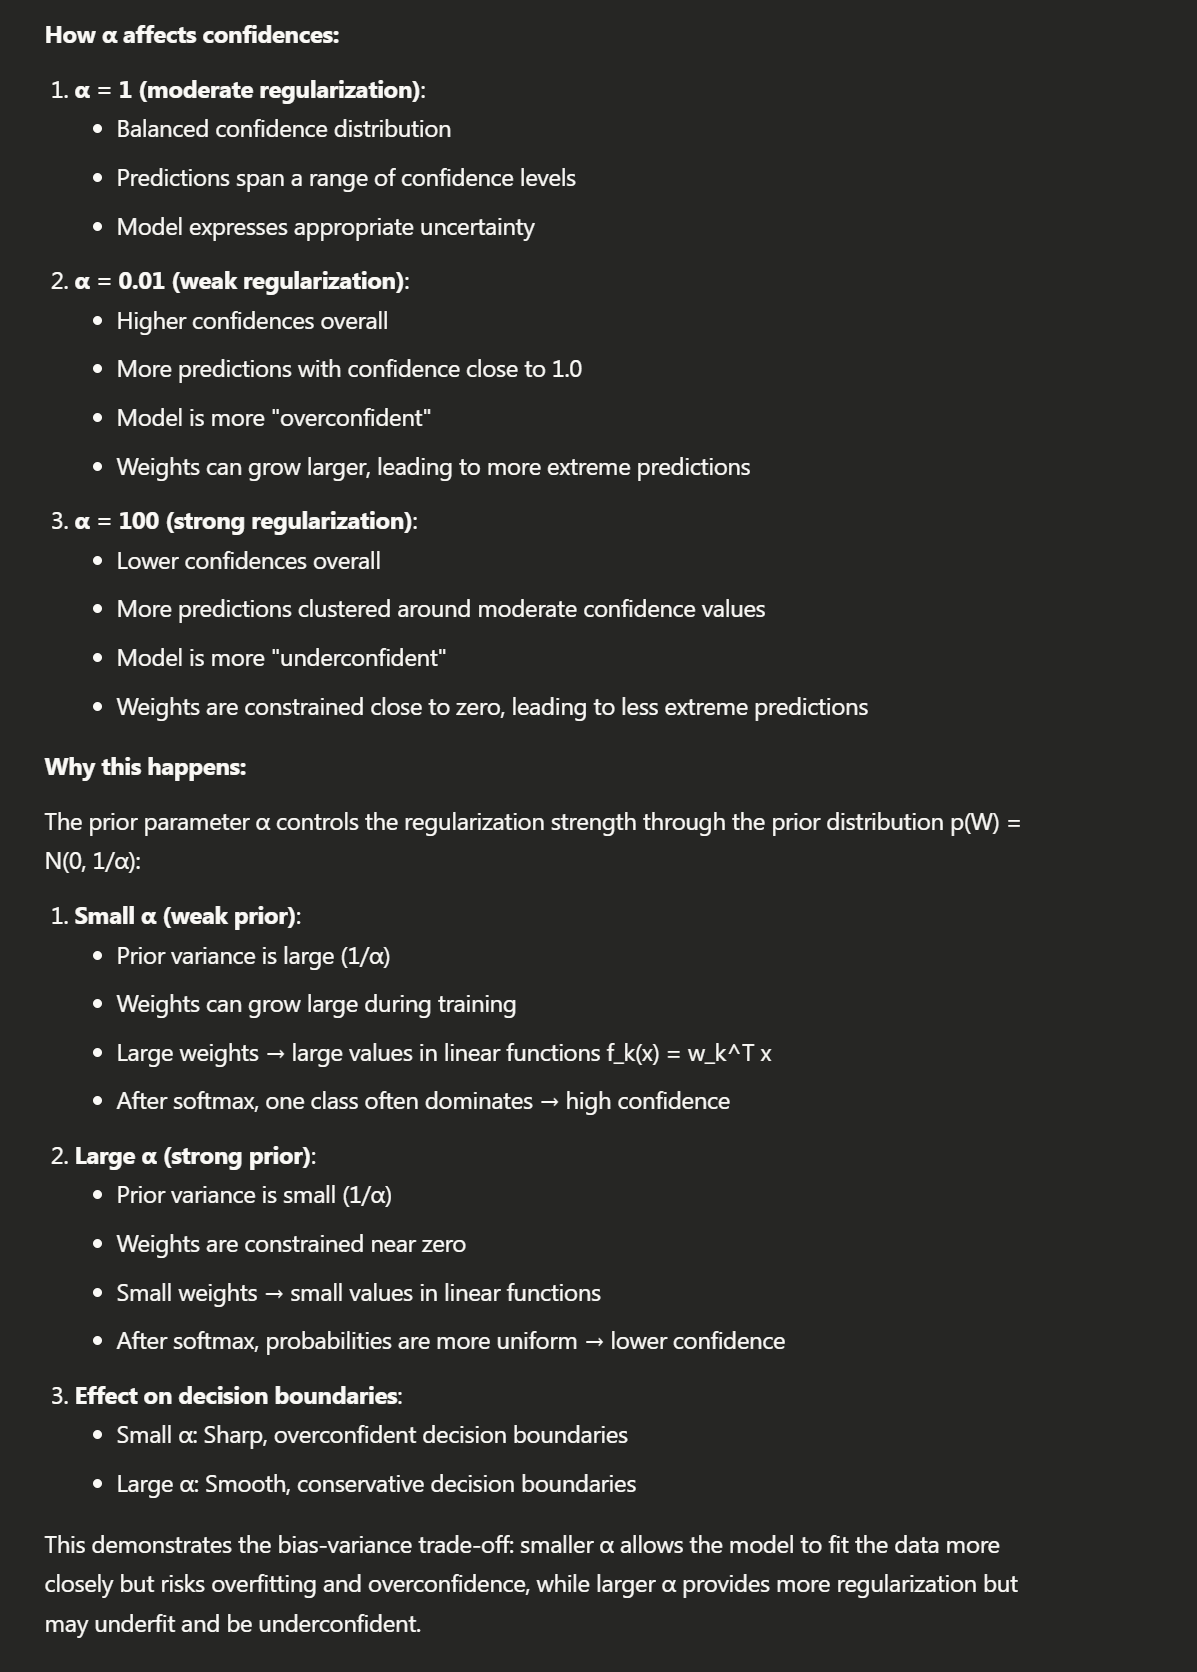


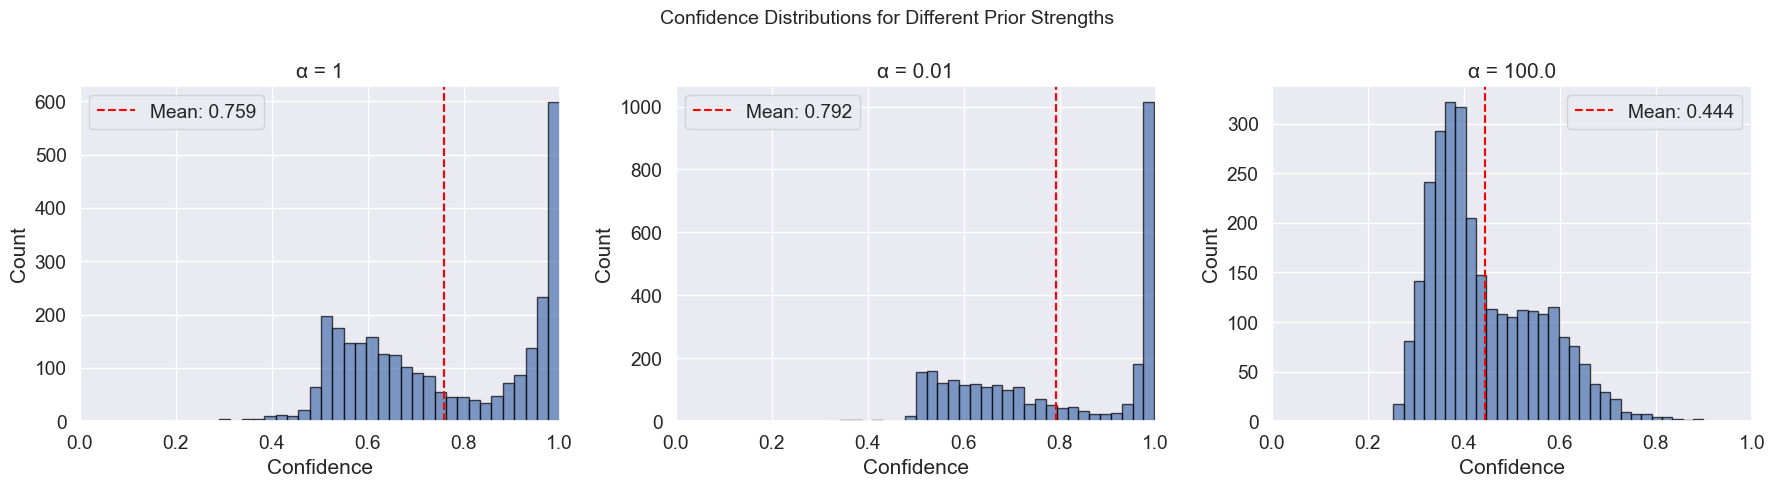

In [44]:
# Define different alpha values to test
alphas = [1, 1e-2, 1e2]

# Create figure for histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, alpha in enumerate(alphas):
    # Fit model with current alpha
    # alpha is the prior precision (inverse variance) for the weights in the Bayesian linear softmax model.
    # - Large alpha: strong prior, weights are forced to be small (model is more "rigid"/regularized)
    # - Small alpha: weak prior, weights can be large (model is more flexible)
    model = BayesianLinearSoftmax(X_train, ytrain, alpha=alpha)
    
    # Get posterior predictive probabilities for test set
    # p_test: shape (num_test_samples, num_classes)
    p_test = model.predict_y(X_test)
    
    # Compute confidence (maximum probability) for each prediction
    # For each test sample, confidence is the highest predicted class probability
    # This measures how "sure" the model is about its prediction for each sample
    confidences = jnp.max(p_test, axis=1)
    
    # Plot histogram of confidence values for this alpha
    axes[i].hist(confidences, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_xlabel('Confidence')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'α = {alpha}')
    axes[i].set_xlim(0, 1)
    
    # Add mean confidence as vertical line for reference
    mean_conf = jnp.mean(confidences)
    axes[i].axvline(mean_conf, color='red', linestyle='--', 
                    label=f'Mean: {mean_conf:.3f}')
    axes[i].legend()

# Add a main title and adjust layout
plt.suptitle('Confidence Distributions for Different Prior Strengths', fontsize=14)
plt.tight_layout()


**Task 5.2**: Implement a function for estimating the expected calibration error (ECE) metric as well as for making a reliability plot. Compute the ECE and the plot reliability for the following values of $\alpha \in \left\lbrace 10^{-2}, 1, 10^2 \right\rbrace$. Compare the reliability plots to the histograms in the previous exercise.




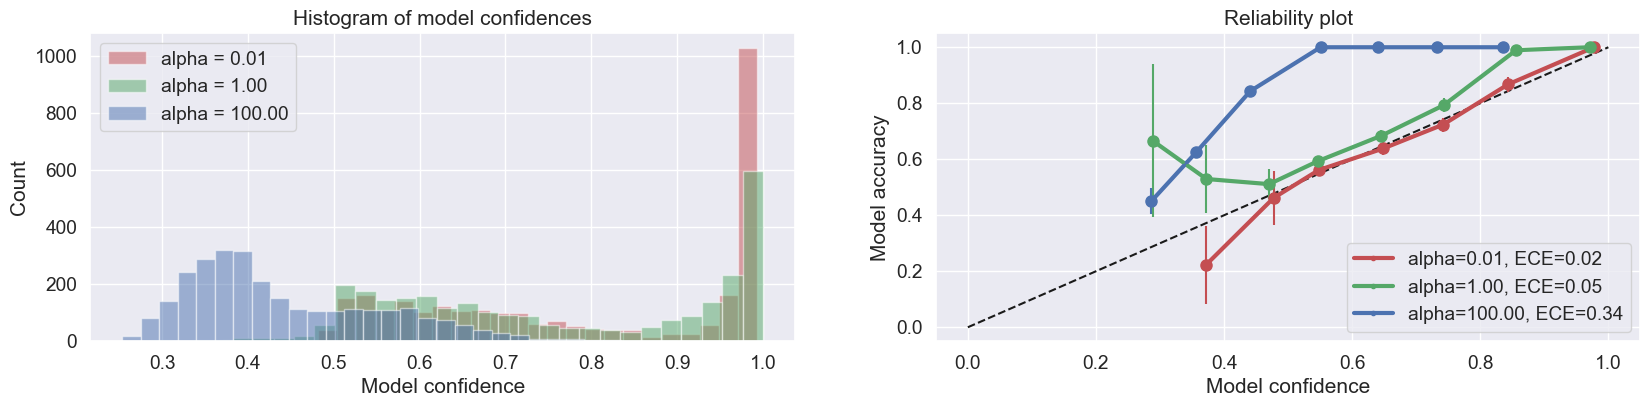

In [45]:
def compute_calibration_curve(ytrue, yhat, probs, num_bins=10):

    # create bins
    bins = jnp.linspace(0, 1, num_bins+1)

    # compute identify correct predictions and compute confidence
    correct_all = 1.0*(ytrue == yhat)
    conf_all = confidence(probs)

    # preallocate lists
    acc_bin, acc_bin_se, conf_bin, point_in_bins = [], [], [], []

    # loop through each bin
    for i in range(num_bins):
        bin_start, bin_end = bins[i], bins[i+1]        
        bin_idx = jnp.logical_and(bin_start <= conf_all, conf_all < bin_end)
        num_points_in_bin = jnp.sum(bin_idx)

        # don't want to bother with empty bins
        if len(correct_all[bin_idx]) == 0:
            continue
        
        # store results
        conf_bin.append(jnp.mean(conf_all[bin_idx]))
        acc = jnp.mean(correct_all[bin_idx])
        acc_bin.append(acc)
        acc_bin_se.append(jnp.sqrt(acc*(1-acc)/num_points_in_bin))
        point_in_bins.append(len(correct_all[bin_idx]))

    acc_bin = jnp.array(acc_bin)
    acc_bin_se = jnp.array(acc_bin_se)
    conf_bin = jnp.array(conf_bin)
    point_in_bins = jnp.array(point_in_bins)

    # compute ECE
    ECE = jnp.sum(point_in_bins*jnp.abs(acc_bin-conf_bin))/len(ytrue)

        
    return ECE, acc_bin, acc_bin_se, conf_bin, point_in_bins

# specify list of alphas
alphas = [1e-2, 1., 1e2]

# prep plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[1].plot([0, 1], [0, 1], 'k--')

def design_matrix(X):
    return jnp.column_stack((jnp.ones(len(X)), X))

for i, alpha in enumerate(alphas):

    # fit model and compute posterior predictive probabilities and predictions (under the 0/1 utility function)
    model = BayesianLinearSoftmax(X_train, ytrain, alpha=alpha)
    ptest = model.predict_y(X_test, 1000)
    ytest_hat = jnp.argmax(ptest, 1)

    ECE, acc, acc_se, conf, num = compute_calibration_curve(ytest, ytest_hat, ptest)
    ax[0].hist(confidence(ptest), 30, alpha=0.5, label=f'alpha = {alpha:3.2f}', color=colors[i])
    ax[1].plot(conf, acc, '.-', label=f'alpha={alpha:3.2f}, ECE={ECE:3.2f}', linewidth=3, color=colors[i])
    ax[1].errorbar(conf, acc, acc_se, color=colors[i], marker='o', markersize=8)


ax[0].set(xlabel='Model confidence', ylabel='Count', title='Histogram of model confidences')
ax[1].set(xlabel='Model confidence', ylabel='Model accuracy', title='Reliability plot')
ax[0].legend()
ax[1].legend()